# Построение модели по прогнозированию оттока клиентов оператора сотовой связи

Оператор связи обратился к нам с задачей по прогнозированию оттока клиентов. На основе полученных предсказаний представители оператора планируют предложить планирующим уйти пользователям промокоды и специальные условия. Команда оператора собрала и предоставила персональные данные о некоторых клиентах, информацию об их тарифах и договорах за период до 1 февраля 2020 года.

Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

**Цель проекта:**

построить модель машинного обучения, которая будет определять клиентов, планирующих расторгнуть контракт. Точность работы модели по метрике AUC-ROC должна быть не менее 0.85.

## Исследовательский анализ данных

### Импортируем библиотеки и извлекаем данные

In [1]:
#!pip install phik

In [141]:

from catboost import (
    CatBoostClassifier, Pool
)
import category_encoders as ce
import copy
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import warnings
from catboost.utils import eval_metric
from imblearn.over_sampling import SMOTE
from IPython.display import display_html
from itertools import chain, cycle
from phik import resources, report
from phik.report import plot_correlation_matrix
from sklearn.ensemble import (
    HistGradientBoostingClassifier
)
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import (
    Ridge, 
    LogisticRegression,
    LogisticRegressionCV
)
from sklearn.metrics import (
    roc_auc_score, 
    make_scorer,
    accuracy_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import (
    Pipeline, make_pipeline
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor 
)
from statsmodels.tools.tools import add_constant 

In [3]:
contract_pth1 = 'C:\\Dataset\\final_provider\\contract.csv'
internet_pth1 = 'C:\\Dataset\\final_provider\\internet.csv'
personal_pth1 = 'C:\\Dataset\\final_provider\\personal.csv'
phone_pth1 = 'C:\\Dataset\\final_provider\\phone.csv'

contract_pth2 = '/datasets/final_provider/contract.csv'
internet_pth2 = '/datasets/final_provider/internet.csv'
personal_pth2 = '/datasets/final_provider/personal.csv'
phone_pth2 = '/datasets/final_provider/phone.csv'

In [4]:
try:
    if os.path.exists(contract_pth1) & os.path.exists(internet_pth1)\
    & os.path.exists(personal_pth1) & os.path.exists(phone_pth1):
        contract = pd.read_csv(contract_pth1)
        internet = pd.read_csv(internet_pth1)
        personal = pd.read_csv(personal_pth1)
        phone = pd.read_csv(phone_pth1)
    elif os.path.exists(contract_pth2) & os.path.exists(internet_pth2)\
    & os.path.exists(personal_pth2) & os.path.exists(phone_pth2):
        contract = pd.read_csv(contract_pth2)
        internet = pd.read_csv(internet_pth2)
        personal = pd.read_csv(personal_pth2)
        phone = pd.read_csv(phone_pth2)
    else:
        print('Проверьте правильность пути к датасету')
except FileNotFoundError as dpe:
        print("Проверьте правильность пути к датасету:", dpe)

pd.set_option('display.max_columns', 50)

### Рассмотрим датафрейм с данными о контрактах

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Количество данных о клиентах (personal) и заключенных контрактах (contract) идентичны. При этом часть клиентов пользуется только услугами интернета, а часть только услугами телефонной связи. Объеденим таблицы. Очевидных пропусков в данных нет.

In [10]:
def unification(left, right, unifying_column):
    df = pd.merge(left, right, how='left', on=unifying_column)
    return df

In [11]:
telecom_data = unification(contract, personal, 'customerID')
telecom_data = unification(telecom_data, internet, 'customerID')
telecom_data = unification(telecom_data, phone, 'customerID')

In [12]:
telecom_data.info()
df_copy = telecom_data.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Заменим пропуски новым значением 'Not connected'. Новое значение, которое не бьется с теми, что имеются в таблице.

In [13]:
telecom_data = telecom_data.fillna('Not connected')

In [14]:
telecom_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not connected
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not connected
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


TotalCharges имеет формат object. Рассмотрим подробнее и исправим на float.

In [15]:
telecom_data.TotalCharges.value_counts() 

20.2       11
           11
19.75       9
19.65       8
19.9        8
           ..
2890.65     1
653.25      1
3410.6      1
7843.55     1
6141.65     1
Name: TotalCharges, Length: 6531, dtype: int64

In [16]:
zero = pd.DataFrame(telecom_data.TotalCharges.unique())

In [17]:
zero.sort_values(0).head(3)

,0
484,
104,100.2
4225,100.25


In [18]:
zero.sort_values(0).tail(3)

,0
3530,999.45
3227,999.8
2755,999.9


In [19]:
telecom_data[telecom_data.TotalCharges == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not connected
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Not connected
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Столбец TotalCharges наравне с числовыми элементами содержит пробел. Очевидно это обусловлено тем, что некоторые клиенты пользуются услугами компании менее месяца. Удалим эти данные, после чего преобразуем остальное во float.

In [20]:
DATEUNLOADING = telecom_data.BeginDate.max() # дата выгрузки данных
print('Дата выгрузки занных:', DATEUNLOADING)

Дата выгрузки занных: 2020-02-01


In [21]:
telecom_data = telecom_data[telecom_data.TotalCharges != ' ']

In [22]:
telecom_data = telecom_data.astype({'TotalCharges': 'float'})

In [23]:
telecom_data.customerID.duplicated().sum()

0

Дубликатов среди идентификационных номеров клиентов не имеется.

#### Преобразуем EndDate в целевой признак.

In [24]:
telecom_data['refused_services'] = np.where(telecom_data.EndDate == 'No', 0, 1)
telecom_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,refused_services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not connected,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not connected,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


Ввели целевой признак refused_services.

#### Построим тепловую карту коррелиции признаков

In [25]:
def heat_map(df, title): # функция для построения тепловой карты
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    codes_plot = sns.heatmap(df, cmap="BrBG", annot=True)
    plt.title(title)
    plt.show()

#### Заменим доп. услуги новым столбцом с информацией о количестве подключенных доп. услуг

In [28]:
def transformation(df, column): # если доп. функция подключена присваиваем 1, если нет - 0 (-1 для заглушки)
    df.loc[df[column] == 'Yes', column] =  1
    df.loc[df[column] == 'No', column] =  0
    df.loc[df[column] == 'Not connected', column] =  -1
    return df[column]

In [29]:
column_int = list(internet.columns)
column_int.remove('customerID')
column_int.remove('InternetService')
print(column_int)
# зафиксировали столбцы с доп. услугами по соответствующей таблице

copy_additional_services = telecom_data[column_int]
# зафиксировали категориальные переменные, потом верну в модель

['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


In [30]:
for col in column_int:
    telecom_data[col] = transformation(telecom_data, col)

telecom_data['additional_services'] = telecom_data[column_int].sum(axis=1).astype(int)
# ввели новый столбец с количеством доп. услуг интернет + телефон

In [31]:
telecom_data['additional_services'].value_counts()

-6    1520
 3    1117
 2    1033
 1     966
 4     850
 0     693
 5     569
 6     284
Name: additional_services, dtype: int64

In [32]:
telecom_data[column_int] = copy_additional_services
# вернули категориальные данные
telecom_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,refused_services,additional_services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not connected,0,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not connected,0,3
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,0


Большинство клиентов пользуются более чем одной дополнительной услугой.

#### Рассмотрим, взаимосвязаны ли отток клиентов и тип контракта

In [33]:
def percentage_pie(df, colmn, ttl, a, b, c, label): # функция для построения двойных круговых диаграмм
    plt.subplot(a, b, c)
    plt.pie(df[colmn],
            labels = label,
            labeldistance = 1.05, 
            wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
            autopct='%1.0f%%');
    plt.title(ttl)

In [34]:
def x(z): # функция для отбора типа контракта в зависимости от оттока клиентов. Используется только для построения графика
    y = telecom_data[telecom_data.refused_services == z]
    y = pd.DataFrame(y.Type.value_counts())
    return y

In [35]:
# Код позаимствован тут:
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>']))):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h3 style="text-align: center;">{title}</h3>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

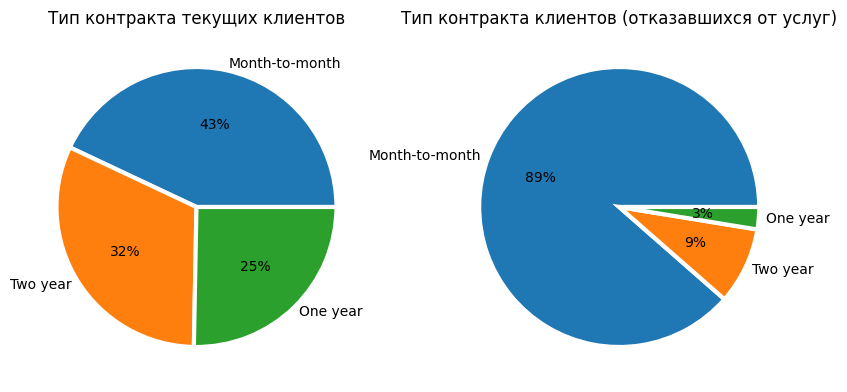

,Type
Month-to-month,2220
Two year,1637
One year,1306
,Type
Month-to-month,1655
One year,166
Two year,48


In [36]:
plt.figure(figsize=(10, 10))

telecom_data_act = x(0)
percentage_pie(telecom_data_act, 'Type', 'Тип контракта текущих клиентов', 2, 2, 1, telecom_data_act.index)


telecom_data_lost = x(1)
percentage_pie(telecom_data_lost, 'Type', 
               'Тип контракта клиентов (отказавшихся от услуг)', 2, 2, 2, telecom_data_act.index)

plt.show()

display_side_by_side(telecom_data_act, telecom_data_lost, 
                     titles=['Тип контракта текущих клиентов', 
                            'Тип контракта клиентов (отказавшихся от услуг)'])

Среди текущих клиентов контракты распределены соизмеримо. Среди клиентов, которые отказались от услуг компании, подавляющее большинство заключали ежемесячный контракт (**89%**). 

При этом среди текущих клиентов все равно в наибольшой степени также преобладает ежемесячный тип контракта (**43%**). 

Возможно их удержание послужит точкой роста. Также это скорее всего приведет к доминирующему преобладанию ежемесячного типа контракта.

#### Введем столбец, фиксирующий продолжительность использования услуг компании, после чего проанализируем новый признак в контексте оттока клиентов

In [37]:
telecom_data.BeginDate = pd.to_datetime(telecom_data.BeginDate, format='%Y-%m-%d')
telecom_data.loc[telecom_data.EndDate == 'No', "EndDate"] = DATEUNLOADING
telecom_data.EndDate = pd.to_datetime(telecom_data.EndDate, format='%Y-%m-%d', )
# Преобразоавли данные в datetime

In [38]:
telecom_data['months_of_use'] = (telecom_data.EndDate - telecom_data.BeginDate).dt.days/30
telecom_data.months_of_use = telecom_data.months_of_use.round().astype(int)
# Добавили столбец с количеством месяцев и округлили до целого числа

<a id='tag_2'></a>

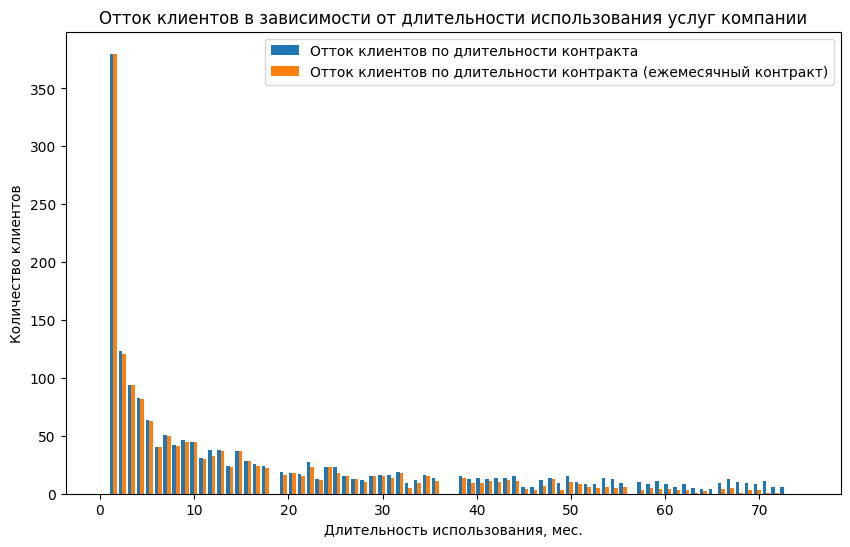

In [40]:
telecom_outflow = telecom_data[telecom_data.refused_services == 1]
telecom_outflow_1 = telecom_data[(telecom_data.refused_services == 1) & (telecom_data.Type == 'Month-to-month')]


plt.figure(figsize = (10, 6))
bins = np.linspace(0, 75, 80)

plt.hist([telecom_outflow.months_of_use, telecom_outflow_1.months_of_use], bins, 
         label=['Отток клиентов по длительности контракта', 
                'Отток клиентов по длительности контракта (ежемесячный контракт)'])
plt.legend(loc='upper right')
plt.title('Отток клиентов в зависимости от длительности использования услуг компании')
plt.xlabel('Длительность использования, мес.')
plt.ylabel('Количество клиентов')
plt.show()

Наибольший отток клиентов наблюдается в первый месяц после заключения контракта. Значение оттока клиентов стабилизируется после полугода использования услуг компании. Подавляющее большинство клиентов, которые расторгли контракт за последние 40 месяцев, заключили ежемесячный контракт.

In [ ]:
telecom_data['day_of_use'] = (telecom_data.EndDate - telecom_data.BeginDate).dt.days
telecom_data.months_of_use = telecom_data.months_of_use.round().astype(int)

Введем новый признак, отражающий длительность использования контракта в днях.

#### Посмотрим на отток клиентов во времени

In [41]:
df_copy.EndDate.value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [42]:
df_copy.BeginDate.value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

In [43]:
telecom_data['year'] = telecom_data.BeginDate.dt.year
telecom_data['year'].value_counts()

2019    1957
2014    1344
2018    1030
2015     852
2017     845
2016     763
2020     233
2013       8
Name: year, dtype: int64

In [44]:
telecom_data['month'] = telecom_data.BeginDate.dt.month
telecom_data['month'].value_counts()

2     793
1     623
9     623
11    621
12    604
10    601
3     590
8     532
6     522
7     518
4     511
5     494
Name: month, dtype: int64

В феврале заключено больше контрактов, нежели в другие месяцы. Возможно имеет место сезонность, но сложно сказать. Части данных о заключенных и уже расторгнутых контрактах у нас нет.

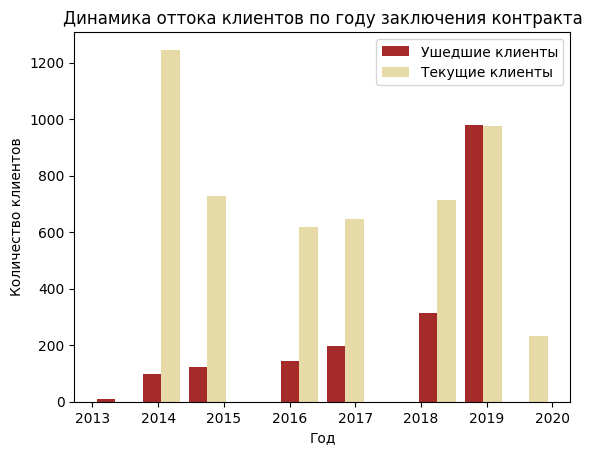

In [45]:
x1 = list(telecom_data[telecom_data['refused_services'] == 1]['year'])
x2 = list(telecom_data[telecom_data['refused_services'] == 0]['year'])

# Assign colors for each airline and the names
colors = ['#A52A2A', '#E6DAA6']
names = ['Ушедшие клиенты', 'Текущие клиенты']

# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Год')
plt.ylabel('Количество клиентов')
plt.title('Динамика оттока клиентов по году заключения контракта')
plt.show()

Представлены неполные данные. Данные об оттоке клиентов представлены только за период с 10.2019 по 02.2020. За период с 10.2013 по 09.2019 представлены только данные о заключенных контрактах, большинство из которых не были расторгнуты. Наибольшее число расторгнутых контрактов были заключены в 2019 году. Но даже в таком контексте наблюдается негативная динамика и увеличение оттока клиентов.

In [46]:
telecom_data_fail = telecom_data[telecom_data['refused_services'] == 1] # отток
telecom_data_corr = telecom_data[telecom_data['refused_services'] == 0] # текущие пользователи

# Выделил по целевому признаку, чтобы каждый раз не срезать

In [47]:
def number_of_clients(df, col_1, col_2, new_col, x, value_varbl, function): 
    # подсчет клиентов, которые пользуются той или иной услугой
    new_df = pd.DataFrame(columns=[new_col], index=range(x))
    z = [value_varbl]
    new_df.iloc[0] = df.query('{} == @z'.format(col_1))[col_1].agg(function) 
    # считаем количество значений по ключевому слову в столбце
    new_df.iloc[1] = df.query('{} == @z'.format(col_2))[col_2].agg(function)
    # считаем количество значений по ключевому слову в столбце
    new_df.iloc[2] = df[col_1].count() - new_df.iloc[0] - new_df.iloc[1]
    # считаем разницу между общим количеством и исключениями по ключевому слову
    new_df.index = ['Телефон', 'Интернет', 'Обе услуги']
    return new_df

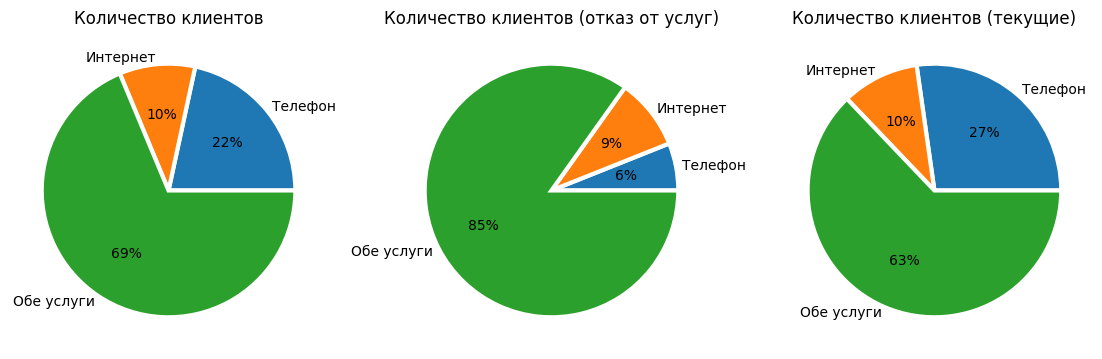

,number_of_clients
Телефон,1520
Интернет,680
Обе услуги,4832
,number_of_clients
Телефон,113
Интернет,170
Обе услуги,1586
,number_of_clients
Телефон,1407
Интернет,510


In [48]:
plt.figure(figsize=(14, 14))

all_service = number_of_clients(telecom_data, 'InternetService', 'MultipleLines',
                 'number_of_clients', 3, 'Not connected', 'count', )
percentage_pie(all_service, 'number_of_clients', 'Количество клиентов', 
               3, 3, 1, 
               all_service.index)

all_service_fail = number_of_clients(telecom_data_fail, 'InternetService', 'MultipleLines',
                 'number_of_clients', 3, 'Not connected', 'count')
percentage_pie(all_service_fail, 'number_of_clients', 'Количество клиентов (отказ от услуг)', 
               3, 3, 2, 
              all_service_fail.index)

all_service_corr = number_of_clients(telecom_data_corr, 'InternetService', 'MultipleLines',
                 'number_of_clients', 3, 'Not connected', 'count')
percentage_pie(all_service_corr, 'number_of_clients', 'Количество клиентов (текущие)', 
               3, 3, 3, 
               all_service_corr.index)

plt.show()

display_side_by_side(all_service, all_service_fail, all_service_corr, 
                     titles=['Количество клиентов', 
                            'Количество клиентов (отказ от услуг)', 
                            'Количество клиентов (текущие)'])

Большинство пользователей пользуются обеими предоставляемыми услугами (**63%** от текущих клиентов). Большинство клиентов отказывают от обеих услуг сразу(**85%**). Также много отказов от услуг интернета(**9%**) при небольшом количестве пользователей только этой услугой(**10%**). Это приводит к увеличению клиентов, которые пользуются только услугами телефонной связи с 22% за все время наблюдений, до 27% на текущий момент.

In [49]:
def bar(a, b, c, xlabel, ylabel, title, x, y): # для графиков
    plt.subplot(a, b, c)
    sns.barplot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

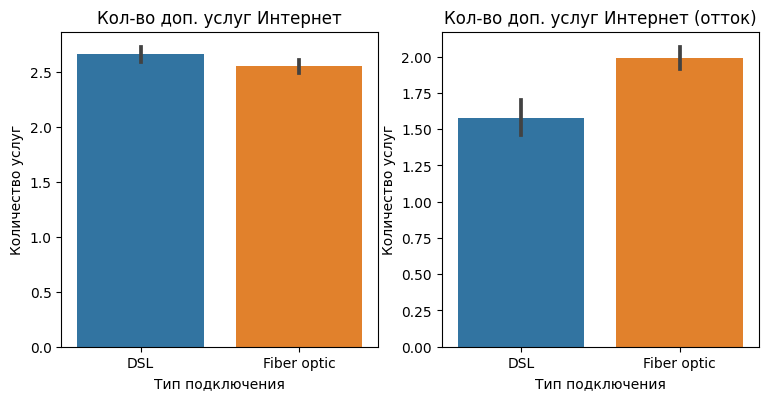

In [50]:
warnings.simplefilter("ignore")
plt.figure(figsize = (9, 9))

x = 'Тип подключения'
y = 'Количество услуг'
df_x = telecom_data[telecom_data.InternetService != 'Not connected'].InternetService
df_y = telecom_data.additional_services
bar(2, 2, 1, x, y, 'Кол-во доп. услуг Интернет', df_x, df_y)

df_x = telecom_data[telecom_data.InternetService != 'Not connected'].InternetService
df_y = telecom_data_fail.additional_services
bar(2, 2, 2, x, y, 'Кол-во доп. услуг Интернет (отток)', df_x, df_y)

plt.show()

В среднем клиенты дополнительно подключают чуть более 2,5 услуг при использовании интернета. У клиентов, отказавшихся от услуг этот показатель ниже и не превышает 2. При этом у пользователей DSL интернета он находится в районе 1.5, что может влиять на средний ежемесячный платеж.

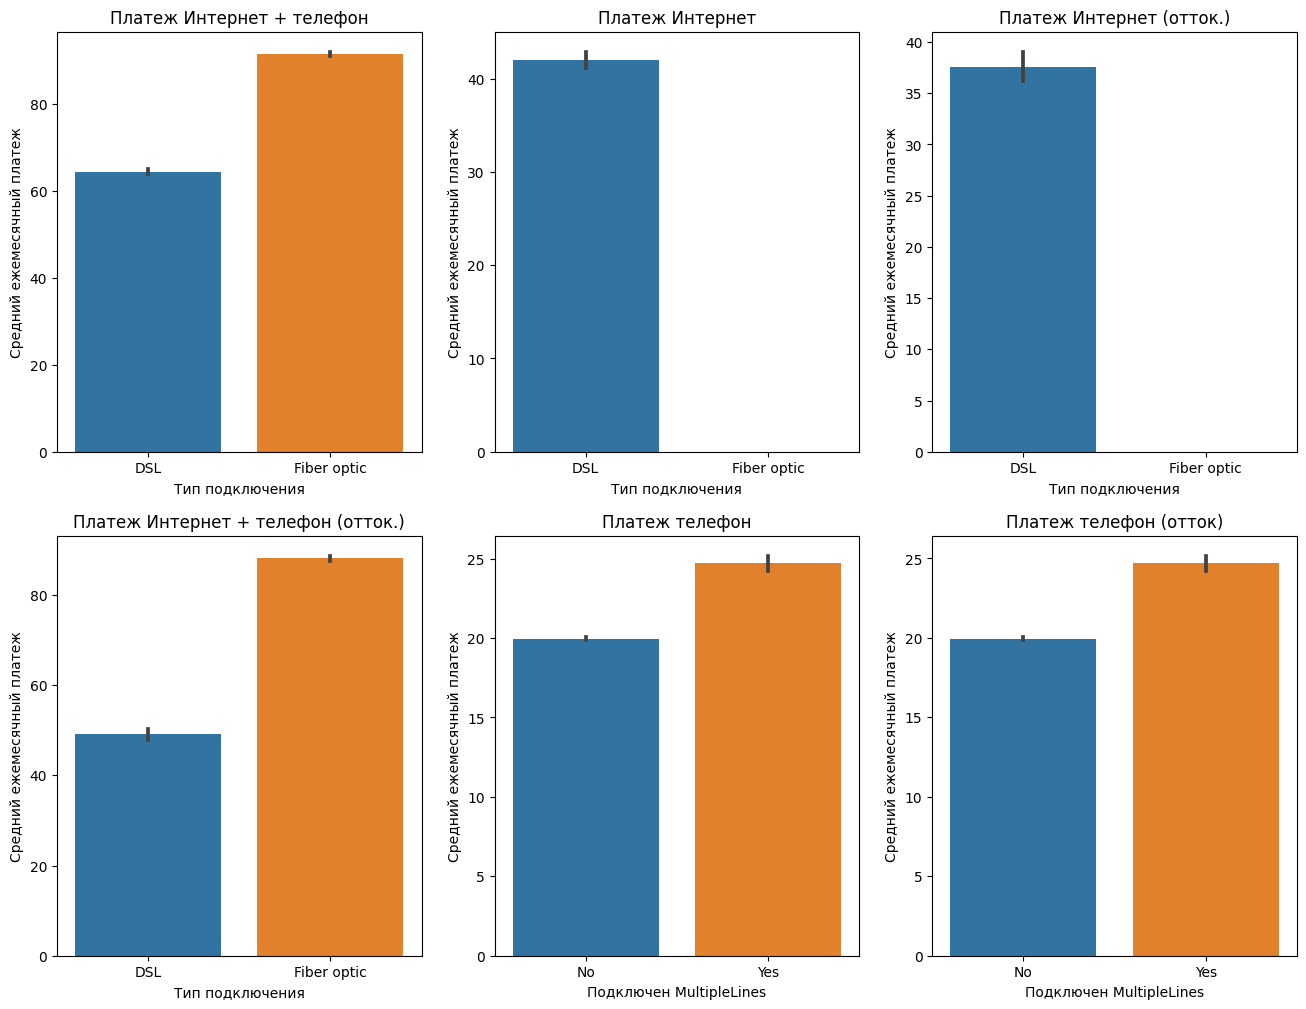

In [51]:
warnings.simplefilter("ignore")
plt.figure(figsize = (16, 12))

x = 'Тип подключения'
y = 'Средний ежемесячный платеж'
z = 'Подключен MultipleLines'

df_x = telecom_data[(telecom_data.InternetService != 'Not connected')].InternetService
df_y = telecom_data[telecom_data.MultipleLines != 'Not connected'].MonthlyCharges
bar(2, 3, 1, x , y, 'Платеж Интернет + телефон', df_x, df_y)

df_x = telecom_data[(telecom_data.InternetService != 'Not connected')].InternetService
df_y = telecom_data[telecom_data.MultipleLines == 'Not connected'].MonthlyCharges
bar(2, 3, 2, x, y, 'Платеж Интернет', df_x, df_y)

df_x = telecom_data[telecom_data.InternetService != 'Not connected'].InternetService
df_y = telecom_data_fail.MonthlyCharges
bar(2, 3, 4, x, y, 'Платеж Интернет + телефон (отток.)', df_x, df_y)

df_x = telecom_data[(telecom_data.InternetService != 'Not connected')].InternetService
df_y = telecom_data_fail[telecom_data_fail.MultipleLines == 'Not connected'].MonthlyCharges
bar(2, 3, 3, x, y, 'Платеж Интернет (отток.)', df_x, df_y)

df_x = telecom_data[(telecom_data.MultipleLines != 'Not connected')].MultipleLines
df_y = telecom_data_fail[telecom_data_fail.InternetService == 'Not connected'].MonthlyCharges
bar(2, 3, 5, z, y, 'Платеж телефон', df_x, df_y)

df_x = telecom_data[(telecom_data.MultipleLines != 'Not connected')].MultipleLines
df_y = telecom_data_fail[telecom_data_fail.InternetService == 'Not connected'].MonthlyCharges
bar(2, 3, 6, z, y, 'Платеж телефон (отток)', df_x, df_y)

plt.show()

In [52]:
temp_df = telecom_data_fail[telecom_data_fail.InternetService != 'Not connected']

display(pd.DataFrame(temp_df.groupby('InternetService')['MonthlyCharges'].mean().round(1)))

,MonthlyCharges
InternetService,
DSL,49.1
Fiber optic,88.1


Действительно, ежемесячный платеж разнится. Ежемесячный платеж лиц, подключенных только к Интернету составляет чуть больше 40. Те, кто пользуются услугами телефонии и DSL платят почти вдвое ниже (**49.1**), нежели клиенты, испольщующие оптоволокно и телефонию (**88.1**). Все клиенты, оплачивающие только подключение к сети Интернет пользуются DSL. Платеж за телефон значительно ниже и похоже что фиксирован. С функцией MultipleLines составляет чуть ниже **25**. 

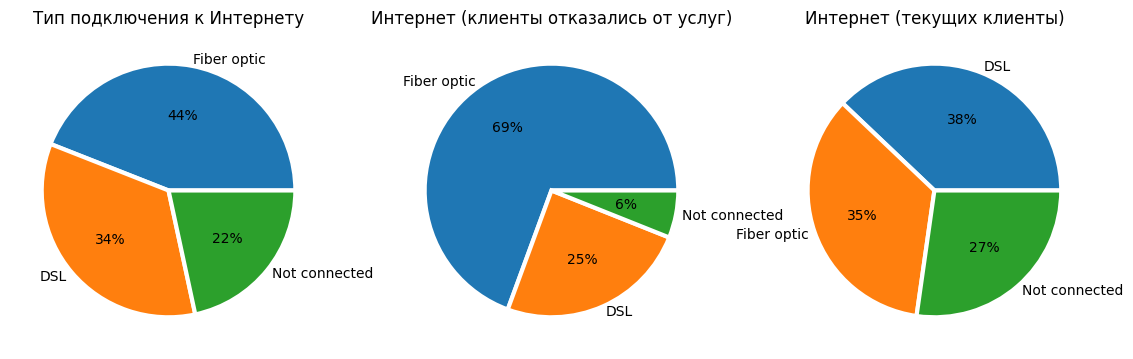

,InternetService
Fiber optic,3096
DSL,2416
Not connected,1520
,InternetService
Fiber optic,1297
DSL,459
Not connected,113
,InternetService
DSL,1957
Fiber optic,1799


In [53]:
plt.figure(figsize=(14, 14))

internet_service = pd.DataFrame(telecom_data.InternetService.value_counts())
percentage_pie(internet_service, 'InternetService', 'Тип подключения к Интернету', 
               3, 3, 1, 
               internet_service.index)

internet_service_fail = pd.DataFrame(telecom_data_fail.InternetService.value_counts())
percentage_pie(internet_service_fail, 'InternetService', 'Интернет (клиенты отказались от услуг)', 
               3, 3, 2, 
               internet_service_fail.index)

internet_service_corr = pd.DataFrame(telecom_data_corr.InternetService.value_counts())
percentage_pie(internet_service_corr, 'InternetService', 'Интернет (текущих клиенты)', 
               3, 3, 3, 
               internet_service_corr.index)

plt.show()

display_side_by_side(internet_service, internet_service_fail, internet_service_corr, 
                     titles=['Тип подключения к Интернету', 
                            'Интернет (клиенты отказались от услуг)', 
                            'Интернет (текущих клиенты)'])

Подавляющее большинство клиентов (**69%**), отказавшихся от услуг интернета пользовались оптоволоконным кабелем. На это стоит обратить внимание. С учетом того, что количество клиентов пользующиеся оптоволоконным кабелем и DSL примерно равно (**32% DSL и 44% оптоволокно**), отток клиентов может быть связан с техническими проблемами или более привлекательными предложениями конкурентов. Также важно заметить, что все пользователи оптоволокном также пользуются и услугами телефонной связи.

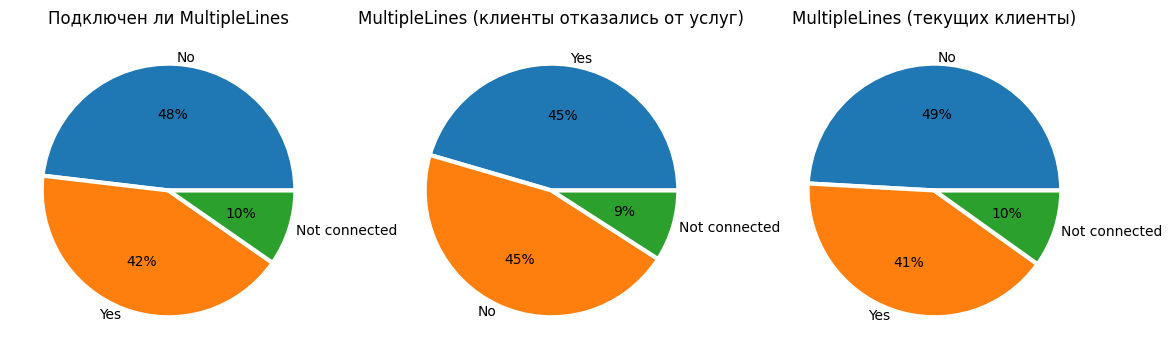

,MultipleLines
No,3385
Yes,2967
Not connected,680
,MultipleLines
Yes,850
No,849
Not connected,170
,MultipleLines
No,2536
Yes,2117


In [54]:
plt.figure(figsize=(14, 14))

multiple_lines = pd.DataFrame(telecom_data.MultipleLines.value_counts())
percentage_pie(multiple_lines, 'MultipleLines', 'Подключен ли MultipleLines', 
               3, 3, 1, 
              multiple_lines.index)

multiple_lines_fail = pd.DataFrame(telecom_data_fail.MultipleLines.value_counts())
percentage_pie(multiple_lines_fail, 'MultipleLines', 'MultipleLines (клиенты отказались от услуг)',
               3, 3, 2, 
               multiple_lines_fail.index)

multiple_lines_corr = pd.DataFrame(telecom_data_corr.MultipleLines.value_counts())
percentage_pie(multiple_lines_corr, 'MultipleLines', 'MultipleLines (текущих клиенты)', 
               3, 3, 3, 
               multiple_lines_corr.index)

plt.show()

display_side_by_side(multiple_lines, multiple_lines_fail, multiple_lines_corr, 
                     titles=['Подключен ли MultipleLines', 
                            'MultipleLines (отказались от услуг)', 
                            'MultipleLines (текущих клиенты)'])

Данные выглядят однородно. От оказания услуг отказываются как те у кого есть MultipleLines, так и те у кого его нет в равной степени (**45%**). При очевидной взаимосвязи подключения интернета и телефона они находятся в разных столбцах, что может затруднить работу модели. Объеденим их в сентетический признак.

In [55]:
telecom_data['phone'] = telecom_data.MultipleLines.copy()
telecom_data.loc[(telecom_data.phone == 'No') |\
                 (telecom_data.phone == 'Yes'), 'phone'] = 'Phone'
telecom_data.loc[telecom_data.phone == 'Not connected','phone'] = ''
# создали новый столбец с информацией о подключение интернета или телефона
telecom_data.loc[telecom_data.InternetService == 'Not connected','InternetService'] = ''

In [56]:
telecom_data['connected_services'] = telecom_data.phone + ' and ' + telecom_data.InternetService
telecom_data['connected_services'] = telecom_data['connected_services'].replace(
    to_replace = 'and\s$', 
    value = '', 
    regex = True
)
telecom_data['connected_services'] = telecom_data['connected_services'].replace(
    to_replace = '^\sand\s', 
    value = '', 
    regex = True
) 

telecom_data.connected_services.value_counts()

Phone and Fiber optic    3096
Phone and DSL            1736
Phone                    1520
DSL                       680
Name: connected_services, dtype: int64

In [57]:
telecom_data.loc[telecom_data.InternetService == '','InternetService'] = 'Not connected'

Синтетический признак с типом подключенных услуг. Соответственно столбцы MultipleLines и InternetService потом удалим

### Сравним средний ежемесячный платеж оставшихся клиентов с теми, кто расторг контракт

In [58]:
telecom_data.MonthlyCharges = telecom_data.MonthlyCharges.round().astype(int)
telecom_data.TotalCharges = telecom_data.TotalCharges.round().astype(int)

In [59]:
display(pd.DataFrame(telecom_data_corr.MonthlyCharges.describe()).T.style.set_caption('Текущие клиенты'))

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,5163.000000,61.307408,31.094557,18.250000,25.100000,64.450000,88.475000,118.750000


In [60]:
telecom_data_fail_cl = pd.DataFrame(telecom_data_fail.MonthlyCharges.describe()).T.reset_index(drop=True)
display(pd.DataFrame(telecom_data_fail.MonthlyCharges.describe()).T.style.set_caption('Ушедшие клиенты'))

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,1869.000000,74.441332,24.666053,18.850000,56.150000,79.650000,94.200000,118.350000


In [61]:
telecom_data_mc = pd.DataFrame(telecom_data.MonthlyCharges.describe()).T
display(telecom_data_mc.style.set_caption('Все клиенты'))

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7032.000000,64.795222,30.087634,18.000000,36.000000,70.000000,90.000000,119.000000


Похоже, что в данных имеется дисбаланс классов. 5 тыс. клиентов с действующим контрактом и менее 2 тыс. расторгли его в октябре 2019 - январе 2020 года.Ежемесячная плата для клиентов варьируется от 18.25 до 118.75 со средним в 61.31. Данные немного смещены к нижнему пределу. Половина клиентов платят 64.45.

Средняя ежемесячная плата клиентов, расторгнувших контракт выше и составляет 74.45, при этоп половина клиентов платили еще больше 79.65. При этом минимальный и максимальный диапазоны сопоставимы (от 18.85 до 118.35) 


Таким образом удержание клиентов может привести к повышению не только выручки, но и среднего чека в ежемесячном выражении. Добавим синтетический признак на основе этих данных.

В сочетании с ежемесячныхми платами и количеством месяцев можно определить, что контракт уже расторгнут. Общие траты оставить не можем. Отталкиваясь от взаимосвязи с ежемесячными выплатами и продолжительностью контракта для всех клиентов введен признак total_charges_category.

In [62]:
telecom_data.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

Часть платежей автоматические. Введем соответствующий бинарный признак

In [63]:
telecom_data['automatic_payment'] = telecom_data.PaymentMethod.copy()
telecom_data.loc[((telecom_data['automatic_payment'] == 'Electronic check') | \
             (telecom_data['automatic_payment'] == 'Mailed check')), 'automatic_payment'] = 'No'
telecom_data.loc[telecom_data['automatic_payment'] != 'No', 'automatic_payment'] = 'Yes'
telecom_data.automatic_payment.value_counts()

No     3969
Yes    3063
Name: automatic_payment, dtype: int64

In [64]:
def categorize_income(df, colmn, index, a, b, c): # синтетический признак на основе среднего из оттока
    try:
        if df[colmn][index] <= a:
            return 'A'
        elif a < df[colmn][index] <= b:
            return 'B'
        elif b < df[colmn][index] <= c:
            return 'C'
        elif c < df[colmn][index]:
            return 'D'
    except:
        pass

In [65]:
telecom_data_fail_t = pd.DataFrame(telecom_data.TotalCharges.describe()).T.reset_index(drop=True)
telecom_data_fail_t

,count,mean,std,min,25%,50%,75%,max
0,7032.0,2283.294653,2266.76967,19.0,401.75,1397.5,3794.25,8685.0


In [66]:
a_m = list(telecom_data_mc.iloc[0, [4]])
b_m = list(telecom_data_mc.iloc[0, [5]])
c_m = list(telecom_data_mc.iloc[0, [6]])
print(a_m, b_m, c_m) # пороги в 25%, 50% и 75% для ежемесячных платежей

[36.0] [70.0] [90.0]


In [67]:
a_t = list(telecom_data_fail_t.iloc[0, [4]])
b_t = list(telecom_data_fail_t.iloc[0, [5]])
c_t = list(telecom_data_fail_t.iloc[0, [6]])
print(a_t, b_t, c_t) # пороги в 25%, 50% и 75% # для платежей вцелом

[401.75] [1397.5] [3794.25]


In [68]:
telecom_data['monthly_charges_category'] = 0
telecom_data['total_charges_category'] = 0

for i in telecom_data.index:    
    telecom_data.monthly_charges_category[i] = categorize_income(telecom_data, 
                                                              'MonthlyCharges',
                                                              i, a_m, b_m, c_m)
    telecom_data.total_charges_category[i] = categorize_income(telecom_data, 
                                                              'TotalCharges',
                                                              i, a_t, b_t, c_t)
telecom_data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,refused_services,additional_services,months_of_use,day_of_use,year,month,phone,connected_services,automatic_payment,monthly_charges_category,total_charges_category
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,30,30,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not connected,0,1,1,31,2020,1,,DSL,No,A,A
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,57,1890,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2,35,1036,2017,4,Phone,Phone and DSL,No,B,C
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,54,108,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2,2,61,2019,10,Phone,Phone and DSL,No,B,A


### Рассмотрим признаки на предмет корреляции

In [71]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'months_of_use', 'additional_services']

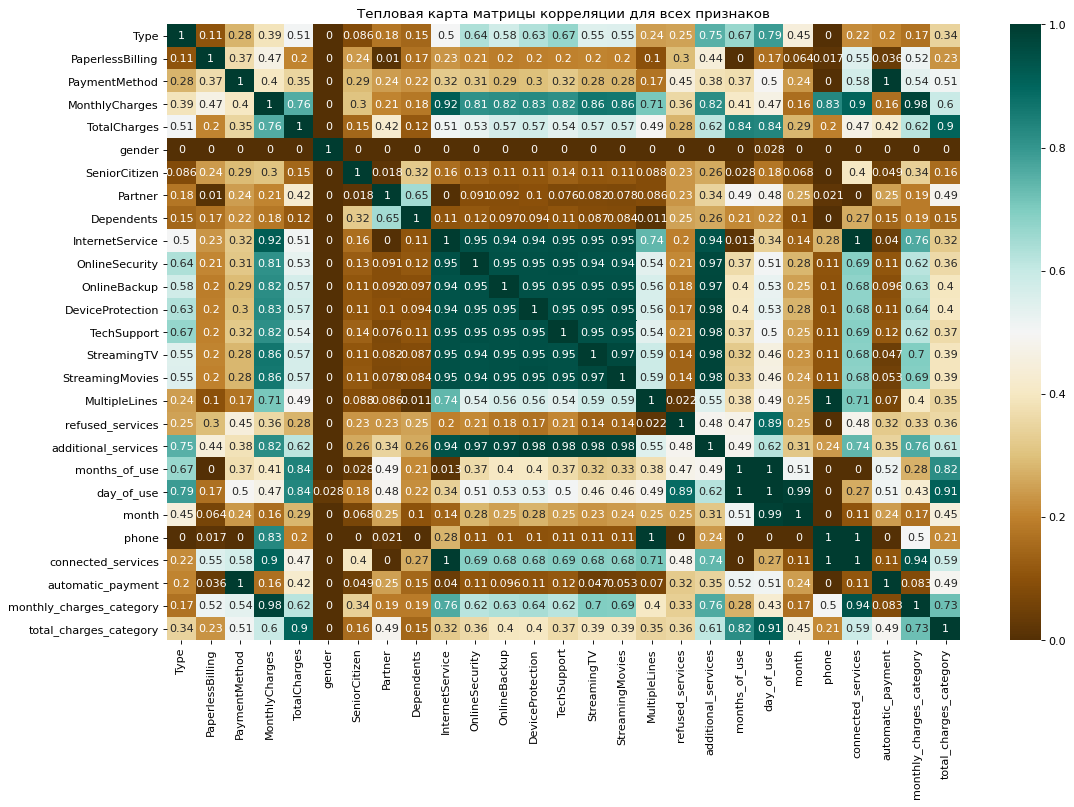

In [72]:
telecom_data_mtx = telecom_data.drop([
                                    'EndDate', 'year', 
                                    'BeginDate', 'customerID'],
                                     axis=1)

heat_map(telecom_data_mtx.phik_matrix(interval_cols), 
         'Тепловая карта матрицы корреляции для всех признаков')
# построили тепловую карту корреляции с учетом категориальных признаков

Многие признаки коррелируют между собой, посмотрим тепловую карту проверки гипотезы о зависимости каждой пары переменных

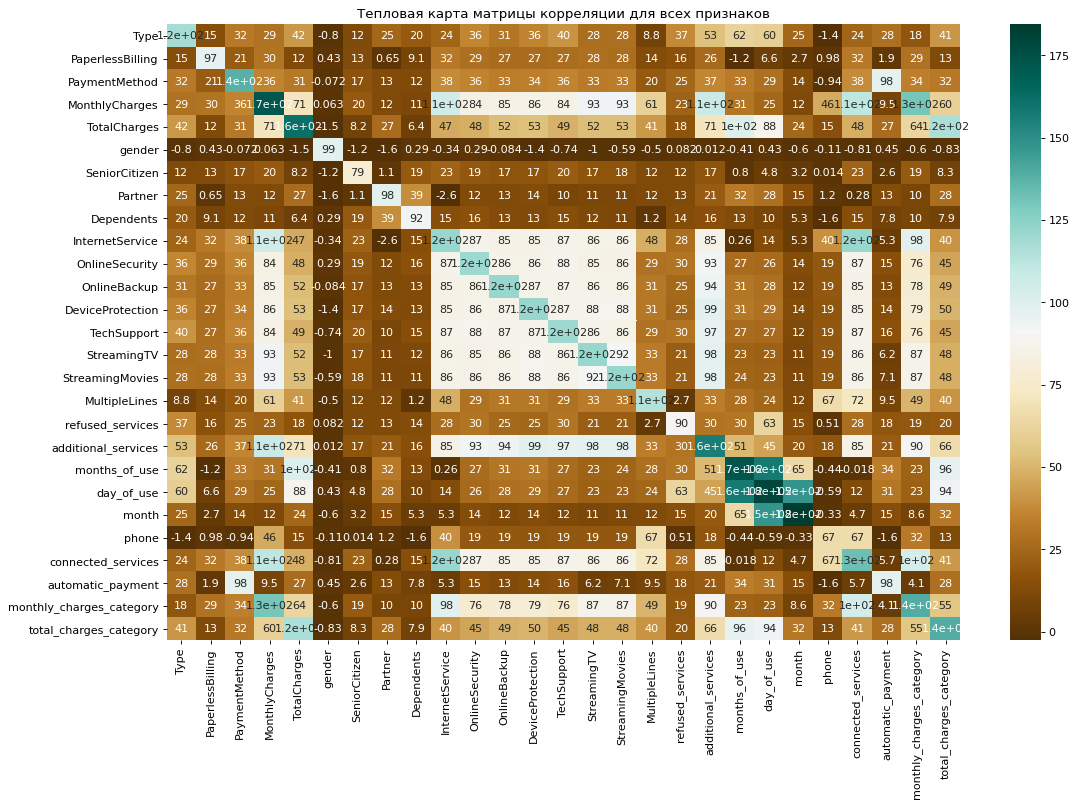

In [73]:
heat_map(telecom_data_mtx.significance_matrix(interval_cols), 
         'Тепловая карта матрицы корреляции для всех признаков')
# построили тепловую карту проверки гипотезы о зависимости каждой пары переменных

Стат значима корреляция между BeginDate(дата заключения контракта) и year(год заключения контракта), months_of_use(сколько месяцев клиент пользуется услугами компании), а также между additional_services(количество услуг) и MonthlyCharges(ежемесячный платеж). Выглядит правдоподобно. При этом все гипотезы о корреляции с целевым признаком refused_services отброшены. 

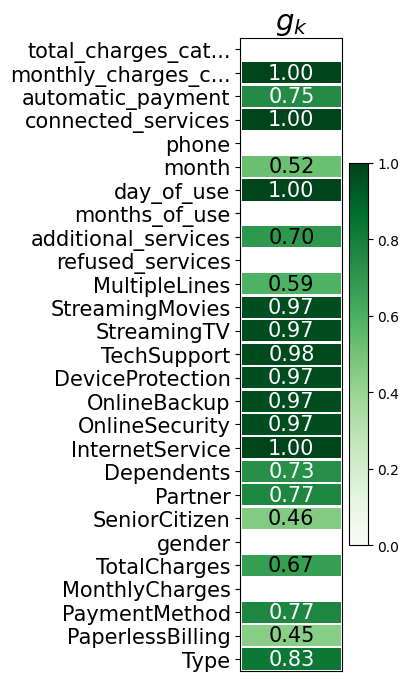

In [74]:
global_correlation, global_labels = telecom_data_mtx.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,7),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)

Глобальная корреляция целевого признака высокая и составляет 0.7

Удаляем столбец EndDate, из которого сформирован целевой признак, BeginDate(дата заключения контракта) поскольку в каждых новых данных она будет смещаться и year(год заключения контракта). Оставим только months_of_use. К тому же у этого признака высокая глобальная корреляция с данными. customerID также удаляем, его фиксировать имеет смысл лишь при развертовании модели, при выгрузке предсказаний. Удаляем столбцы InternetService и MultipleLines, поскольку на их основе создан синтетический признак.

In [75]:
telecom_data.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,refused_services,additional_services,months_of_use,day_of_use,year,month,phone,connected_services,automatic_payment,monthly_charges_category,total_charges_category
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,30,30,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not connected,0,1,1,31,2020,1,,DSL,No,A,A


In [76]:
clear_telecom_datа = telecom_data.drop(['EndDate', 'year', 
                                       'BeginDate', 'customerID', 
                                        #'month','phone',
                                    ],
                                 axis=1)

# 'MonthlyCharges'  'total_charges_category'   'OnlineSecurity',  'TechSupport', ,
# 'OnlineBackup'  'TotalCharges' 
#'gender', 'MultipleLines' 'monthly_charges_category',
#     total_charges_category'                       'Dependents', 'Partner', 'DeviceProtection', 
#                                    'StreamingTV', 'StreamingMovies', 'SeniorCitizen'

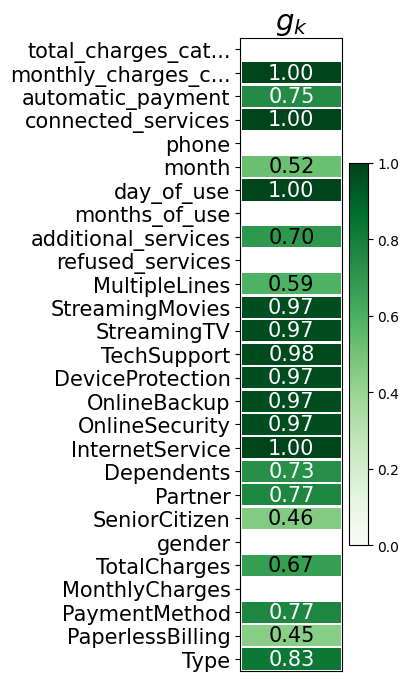

In [78]:
global_correlation, global_labels = clear_telecom_datа.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,7),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)

#### Посмотрим на динамику расторжения контрактов

In [79]:
telecom_data.BeginDate.sort_values()

4513   2013-10-01
4610   2013-10-01
3439   2013-10-01
975    2013-11-01
3040   2013-11-01
          ...    
211    2020-01-01
6381   2020-01-01
3509   2020-01-01
3376   2020-01-01
0      2020-01-01
Name: BeginDate, Length: 7032, dtype: datetime64[ns]

In [80]:
telecom_data_fail.groupby('EndDate')['refused_services'].count()

EndDate
2019-10-01    458
2019-11-01    485
2019-12-01    466
2020-01-01    460
Name: refused_services, dtype: int64

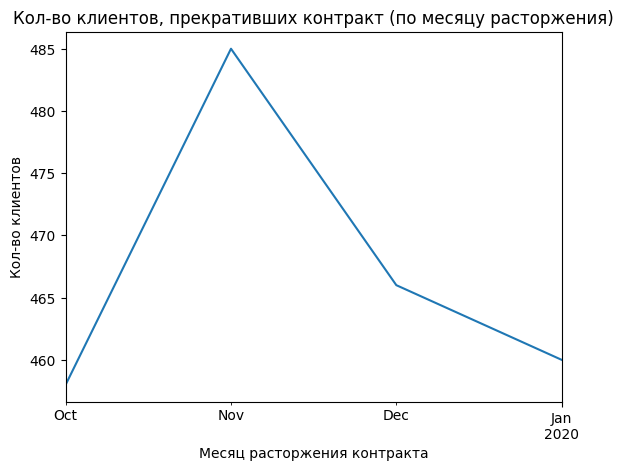

In [81]:
telecom_data_fail.groupby('EndDate')['refused_services'].count().plot()
plt.title('Кол-во клиентов, прекративших контракт (по месяцу расторжения)')
plt.xlabel('Месяц расторжения контракта')
plt.ylabel('Кол-во клиентов')
plt.show()

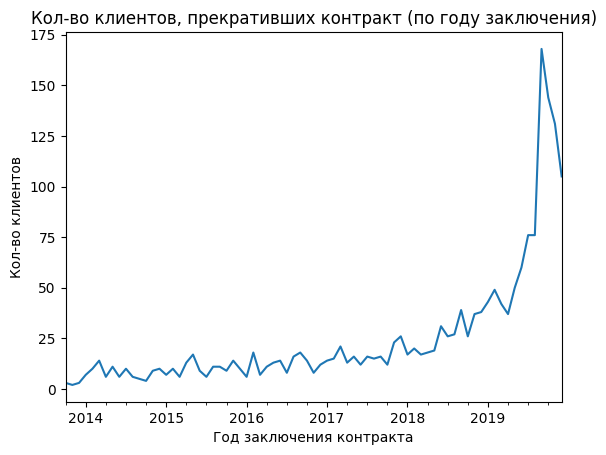

In [82]:
telecom_data_fail.groupby('BeginDate')['refused_services'].count().plot()
plt.title('Кол-во клиентов, прекративших контракт (по году заключения)')
plt.xlabel('Год заключения контракта')
plt.ylabel('Кол-во клиентов')
plt.show()

Количество расторгнутых контрактов выглядит равномерно с пиком в ноябре 2019 года. Данные по расторгнутым контрактам лишь за период с октября 2019 по января 2020. Однако в контексте даты заключения контракта данные распределены более равномерно. 


Странно, но многие локальные пики приходятся на контракты, заключенные первые месяцы года.


Поскольку данные по оттоку представлены за 4 месяца, а по заключению контракта за несколько лет, временным рядом их считать нельзя. Делить выборки будем исходя из этого.

**Выводы:**

1. **В данных имелось небольшое количество пропусков, скорее всего связанных с особенностью выгрузки данных.** Она касается контрактов, заключенных в месяц выгрузки. Данные удалены как неинформативные. Целевой признак сформирован на основе информации об окончании контракта (EndDate). Дубликатов в данных нет.


2. К услугам использования интернета (InternetService) предлагаются до 6 дополнительных услуг. Их количество выделено в отдельный признак (**additional_services**).


3. Среди текущих клиентов контракты распределены соизмеримо. **Среди клиентов, которые отказались от услуг компании, подавляющее большинство заключали ежемесячный контракт (89%).** Для случайного леса закодируем его прямым кодированием.


4. Введен признак, отражающий длительность использования услуг компании (**months_of_use**). Наибольший отток клиентов наблюдается в первый месяц после заключения контракта. Значение оттока клиентов стабилизируется после полугода использования услуг компании.


5. Представлены неполные данные. **Данные об оттоке клиентов представлены только за период с 10.2019 по 02.2020**. За период с 10.2013 по 09.2019 представлены только данные о заключенных контрактах, большинство из которых не были расторгнуты. Наибольшее число расторгнутых контрактов были заключены в 2019 году. Но даже в таком контексте наблюдается негативная динамика и увеличение оттока клиентов.


6. Подавляющее большинство клиентов (**69%**), отказавшихся от услуг интернета пользовались оптоволоконным кабелем. На это стоит обратить внимание с учетом того, что количество клиентов пользующиеся оптоволоконным кабелем и DSL примерно равно  (**32% DSL и 44% оптоволокно**).


7. Исходя из того, что 68% пользуются услугами интенета и телефона, информаци об этом объединена в признак **connected_services**.


8. Введены категориальные признаки (**monthly_charges_category, total_charges_category**) делящие ежемесячные выплаты(MonthlyCharges) и общие выплаты(TotalCharges) в зависимости от квантилей.


**Синтетические признаки:**

- **additional_services** - отражает количество активных дополнительных услуг у пользователей Интернета. Выведен из признаков (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)


- **months_of_use** - отражает длительность услуг. Выведен из признаков EndDate и BeginDate.


- **connected_services** - отражает, какой тим Интернет соеденения и телефонной связи имеет клиент. Выведен из признаков InternetService и MultipleLines


- **monthly_charges_category** - отражает квантили ежемесячных трат из признака MonthlyCharges.



- **total_charges_category** - отражает квантили ежемесячных трат из признака TotalCharges.

#### Преобразуем данные порядкового кодирования, чтогбы оценит коэффициент инфляции диспресии

In [83]:
ohe_features_df = clear_telecom_datа.select_dtypes(include='object').columns.to_list()
ohe_features_df

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'phone',
 'connected_services',
 'automatic_payment',
 'monthly_charges_category',
 'total_charges_category']

In [84]:
num_features = clear_telecom_datа.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
print(num_features)

['MonthlyCharges', 'TotalCharges', 'refused_services', 'additional_services', 'months_of_use', 'day_of_use', 'month']


In [85]:
col_transformer_df= make_column_transformer(
    (
        OrdinalEncoder(), 
        ohe_features_df
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)
col_transformer_df

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'gender', 'Partner', 'Dependents',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'MultipleLines', 'phone',
                                  'connected_services', 'automatic_payment',
                                  'monthly_charges_category',
                                  'total_charges_category']),
                                ('standardscaler', StandardScaler(),
                                 ['MonthlyCharges', 'TotalCharges',
                                  'refused_services', 'additional_services',
                                  'months_of_use', 'day_of_use', 'month'])])

In [86]:
transform_telecom_datа = pd.DataFrame(
    col_transformer_df.fit_transform(clear_telecom_datа),
    columns=col_transformer_df.get_feature_names_out()
)

In [87]:
transform_telecom_datа.head(3)

,ordinalencoder__Type,ordinalencoder__PaperlessBilling,ordinalencoder__PaymentMethod,ordinalencoder__gender,ordinalencoder__Partner,ordinalencoder__Dependents,ordinalencoder__InternetService,ordinalencoder__OnlineSecurity,ordinalencoder__OnlineBackup,ordinalencoder__DeviceProtection,ordinalencoder__TechSupport,ordinalencoder__StreamingTV,ordinalencoder__StreamingMovies,ordinalencoder__MultipleLines,ordinalencoder__phone,ordinalencoder__connected_services,ordinalencoder__automatic_payment,ordinalencoder__monthly_charges_category,ordinalencoder__total_charges_category,standardscaler__MonthlyCharges,standardscaler__TotalCharges,standardscaler__refused_services,standardscaler__additional_services,standardscaler__months_of_use,standardscaler__day_of_use,standardscaler__month,remainder__SeniorCitizen
0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.156545,-0.994126,-0.601663,0.067282,-1.275904,-1.280334,-1.517644,0.0
1,1.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,-0.259102,-0.173517,-0.601663,0.327240,0.084739,0.064866,-0.678887,0.0
2,0.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,-0.358818,-0.959713,1.662059,0.327240,-1.235886,-1.240179,0.998629,0.0


In [88]:
pd.Series([variance_inflation_factor(transform_telecom_datа.values, i) 
           for i in range(transform_telecom_datа.shape[1])],
           index=transform_telecom_datа.columns)

ordinalencoder__Type                            2.633040
ordinalencoder__PaperlessBilling                1.208637
ordinalencoder__PaymentMethod                   5.495822
ordinalencoder__gender                          1.002437
ordinalencoder__Partner                         1.467608
ordinalencoder__Dependents                      1.382025
ordinalencoder__InternetService             33258.649181
ordinalencoder__OnlineSecurity                875.970483
ordinalencoder__OnlineBackup                 1025.714842
ordinalencoder__DeviceProtection             1024.251931
ordinalencoder__TechSupport                   884.543233
ordinalencoder__StreamingTV                   939.244535
ordinalencoder__StreamingMovies               947.297880
ordinalencoder__MultipleLines                   6.324173
ordinalencoder__phone                       78500.798104
ordinalencoder__connected_services          97013.550070
ordinalencoder__automatic_payment               5.617587
ordinalencoder__monthly_charges

У признаков  MonthlyCharges, PaymentMethod, connected_services, monthly_charges_category, total_charges_category, additional_services и months_of_use высокии коэфициенты инфляции дисперсии. Что естественно, поскольку часть из них является синтетическими. Оставим months_of_use, покольку это единственная привязка ко времени.

In [89]:
transform_telecom_datа_v1 = transform_telecom_datа.drop(['ordinalencoder__total_charges_category',
                                                        'ordinalencoder__monthly_charges_category',
                                                         #'standardscaler__additional_services',
                                                         #'ordinalencoder__connected_services',
                                                         'standardscaler__months_of_use',
                                                        #'ordinalencoder__PaymentMethod',
                                                          #'standardscaler__TotalCharges',
                                                        'standardscaler__MonthlyCharges',
                                                        #'ordinalencoder__MultipleLines',
                                                         #'ordinalencoder__gender',
                                                         #'ordinalencoder__automatic_payment',
                                                         #'ordinalencoder__OnlineSecurity',
                                                        #'ordinalencoder__OnlineBackup',
                                                        #'ordinalencoder__DeviceProtection',
                                                        #'ordinalencoder__TechSupport',
                                                        #'ordinalencoder__StreamingTV',
                                                        #'ordinalencoder__StreamingMovies',
                                                         'ordinalencoder__InternetService',
                                                         'ordinalencoder__phone',
                                                         'standardscaler__month'
                                                         
    
], axis=1)

In [90]:
pd.Series([variance_inflation_factor(transform_telecom_datа_v1.values, i) 
           for i in range(transform_telecom_datа_v1.shape[1])],
           index=transform_telecom_datа_v1.columns)

ordinalencoder__Type                   4.226091
ordinalencoder__PaperlessBilling       2.841440
ordinalencoder__PaymentMethod          8.314865
ordinalencoder__gender                 1.980865
ordinalencoder__Partner                2.791373
ordinalencoder__Dependents             1.968274
ordinalencoder__OnlineSecurity         2.351911
ordinalencoder__OnlineBackup           2.440676
ordinalencoder__DeviceProtection       2.653071
ordinalencoder__TechSupport            2.513119
ordinalencoder__StreamingTV            3.009351
ordinalencoder__StreamingMovies        3.050360
ordinalencoder__MultipleLines          2.510375
ordinalencoder__connected_services     7.451084
ordinalencoder__automatic_payment      5.219257
standardscaler__TotalCharges           8.618886
standardscaler__refused_services       1.365532
standardscaler__additional_services    2.315547
standardscaler__day_of_use             7.179442
remainder__SeniorCitizen               1.357214
dtype: float64

У признаков TotalCharges, day_of_use, PaymentMethod, connected_services все еще наблюдается повышенная инфляция дисперсии, но в рамках разумного. Удалим признаки исходя из этих данных.

In [91]:
clear_telecom_datа = telecom_data.drop(['EndDate', 'year', 
                                       'BeginDate', 'customerID', 
                                        'month', #'TotalCharges',
                                        'phone', 'MonthlyCharges',
                                        'monthly_charges_category',
                                        'months_of_use'],
                                     axis=1)


clear_telecom_datа.shape 

(7032, 22)

Признаки phone и monthly_charges_category в обучении модели случайного леса имели значимость, близкую к 0

In [92]:
regr_coln_drop = [#'PaymentMethod',
                  'total_charges_category', #'connected_services', 
                  'InternetService'
                  ]

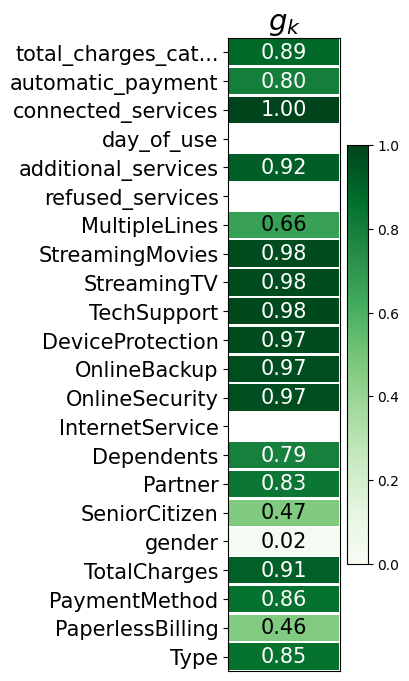

In [93]:
global_correlation, global_labels = clear_telecom_datа.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,7),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)

### Разделение выборки на обучающую и тестовую

In [94]:
RANDOM_STATE = 130223

In [95]:
tel_targ = clear_telecom_datа.refused_services

tel_features = clear_telecom_datа.drop('refused_services', axis=1)

#### Выделяем выборку для случайного леса без учета коэффециента инфляции дисперсии

In [96]:
# делим выборки с учетом дисбаланса классов, применяя стратификацию для случайного леса
X_train_rforest, X_test_rforest, y_train, y_test = train_test_split(tel_features,
                                                          tel_targ,
                                                          stratify=tel_targ,
                                                          test_size=.25,
                                                          random_state=RANDOM_STATE)

In [97]:
X_train_rforest.shape,  y_train.shape, X_test_rforest.shape, y_test.shape

((5274, 21), (5274,), (1758, 21), (1758,))

In [98]:
y_train.sum(), y_test.sum()

(1402, 467)

Данные разделены на обучающие и текстовые в соотношении 3/1

#### Выделяем выборку для регрессии без учета коэффециента инфляции дисперсии

In [99]:
X_train_regresion = X_train_rforest.drop(regr_coln_drop, axis=1) 
X_test_regresion =  X_test_rforest.drop(regr_coln_drop, axis=1) 
# выделяем выборку для обучения и теста регрессии с учетом инфляции дисперсии

In [100]:
X_train_regresion.shape,  y_train.shape, X_test_regresion.shape, y_test.shape

((5274, 19), (5274,), (1758, 19), (1758,))

Удаляем признаки, которые показали на лучшей модели значимость близкую к 0:

- onehotencoder__Partner_Yes:	**0.834%**
- onehotencoder__Dependents_Yes:	**0.722%**
- onehotencoder__gender_Male:	**0.507%**
- onehotencoder__MultipleLines_Yes:	**0.450%**
- remainder__SeniorCitizen:	**0.352%**
- onehotencoder__MultipleLines_Not connected:	**0.283%**

In [101]:
#X_train_rforest = X_train_rforest.drop(['MultipleLines', 'SeniorCitizen', 'Partner', 'Dependents'], axis=1)
#X_test_rforest = X_test_rforest.drop(['MultipleLines', 'SeniorCitizen', 'Partner', 'Dependents'], axis=1)

#### Применим прямое кодирование и масштабируем признаки

##### Категориальные признаки для OHE регрессии

In [102]:
ohe_features = X_train_regresion.select_dtypes(include='object').columns.to_list()
ohe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'connected_services',
 'automatic_payment']

##### Категориальные признаки для прямого кодирования под случайный лес


In [103]:
ohe_features_rf = X_train_rforest.select_dtypes(include='object').columns.to_list()
#ohe_features_rf.remove('PaperlessBilling')
#ohe_features_rf.remove('monthly_charges_category')
ohe_features_rf.remove('Type')
ohe_features_rf

['PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'connected_services',
 'automatic_payment',
 'total_charges_category']

##### Численные признаки для масштабирования регрессии



In [104]:
num_features = X_train_regresion.select_dtypes(exclude='object').columns.to_list()
#num_features.remove('SeniorCitizen')
print(num_features)

['TotalCharges', 'SeniorCitizen', 'additional_services', 'day_of_use']


##### Численные признаки для случайного леса

In [105]:
num_features_rf = X_train_rforest.select_dtypes(exclude='object').columns.to_list()
#num_features_rf.remove('SeniorCitizen')
print(num_features_rf)

['TotalCharges', 'SeniorCitizen', 'additional_services', 'day_of_use']


##### Трансформер для OHE


In [106]:
col_transformer = make_column_transformer( 
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

col_transformer # условия применения OHE и масштабирования

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'gender', 'Partner', 'Dependents',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies',
                                  'MultipleLines', 'connected_services',
                                  'automatic_payment']),
                                ('standardscaler', StandardScaler(),
                                 ['TotalCharges', 'SeniorCitizen',
                                  'additional_services', 'day_of_use'])],
                  verbose_feature_names_out=False)

##### Трансформер под случайный лес

In [107]:
col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(
            drop='first',
            handle_unknown='ignore'
        ), 
        ohe_features_rf
    ),
    (
        OrdinalEncoder(
 ), 
        ['Type']
        
    ),
    (
        StandardScaler(), 
        num_features_rf
    ),
    remainder='passthrough'
)
col_transformer_rf

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['PaperlessBilling', 'PaymentMethod', 'gender',
                                  'Partner', 'Dependents', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies',
                                  'MultipleLines', 'connected_services',
                                  'automatic_payment',
                                  'total_charges_category']),
                                ('ordinalencoder', OrdinalEncoder(), ['Type']),
                                ('standardscaler', StandardScaler(),
                                 ['TotalCharges', 'SeniorCitizen',
                                  'additional_services', 'day_of_use'])])

In [109]:
def train_model_gs(name_model, transformer, scoring, cv, x, y, random_state, param):
    model = name_model(random_state=random_state, class_weight='balanced')
    
    pipeline = make_pipeline(transformer, model)
    
    gs = GridSearchCV(
    pipeline, 
    param_grid=param, 
    scoring=scoring,
    refit='roc_auc',
    n_jobs=-1,
    cv=cv)
    
    gs.fit(x, y)
        
    return gs
# функция для модели с GridSearchCV

In [110]:
def best_metric(name_model, model):
    accurasy = model.best_score_ # фиксируем AUC
    best_params = model.best_params_

    reslt = pd.DataFrame(model.cv_results_) 
    best_model_reslt = reslt.loc[model.best_index_]
    accuracy = best_model_reslt['mean_test_accuracy'] # фиксируем accurasy
    f1 = best_model_reslt['mean_test_f1'] # фиксируем f1
    
    metrics = [[name_model, accurasy, accuracy, f1]]
    metrics_to_df = pd.DataFrame(metrics, columns=['model', 'AUC', 'F1', 'Accurasy'])
    
    print(f'best_params: {best_params}')
    print('AUC: {:.3f}'.format(accurasy))
    print('Accuracy: {:.3f} \nF1: {:.3f}'.format(
    accuracy, f1))
    return metrics_to_df

### Подбираем гиперпараметры с помощью GridSearchCV для модели логистической регрессии

In [111]:
%%time
param_LR = {'logisticregression__solver': ['newton-cg', 'lbfgs', 
                                           'liblinear', 'sag', 'saga'],
            'logisticregression__C': np.linspace(0, .5, 50)
}



gs_lr = train_model_gs(LogisticRegression, col_transformer, 
                          ['roc_auc', 'accuracy', 'f1'], 5, 
                          X_train_regresion, y_train, 
                          RANDOM_STATE, param_LR)

lr_metric = best_metric('LogisticRegression', gs_lr)

best_params: {'logisticregression__C': 0.5, 'logisticregression__solver': 'liblinear'}
AUC: 0.845
Accuracy: 0.754 
F1: 0.632
CPU times: total: 13.8 s
Wall time: 55.6 s


### Подбираем гиперпараметры с помощью GridSearchCV для модели случайного леса


#### Отберем лучшие параметры модели с помощью RandomizedSearchCV

In [113]:
def train_model_rs(name_model, transformer, scoring, cv, x, y, random_state, param):
    model = name_model(random_state=random_state)
    
    pipeline = make_pipeline(transformer, model)
    
    gs = RandomizedSearchCV(
    pipeline, 
    param_distributions=param, 
    scoring=scoring, 
    n_jobs=-1,
    n_iter=100,
    refit='roc_auc',
    cv=cv,
    random_state=random_state)
    
    gs.fit(x, y)
    
    return gs
# функция для модели с RandomizedSearchCV

In [114]:
%%time
param_grid_rf = {
    'randomforestclassifier__n_estimators': range(25, 1000, 25), 
    'randomforestclassifier__max_depth': range(2, 50, 1),
    'randomforestclassifier__max_features': ['log2', 'sqrt'],
    'randomforestclassifier__min_weight_fraction_leaf': np.arange(0.001, .1, .001),
    'randomforestclassifier__min_samples_split': range(2, 15, 1),
    'randomforestclassifier__min_samples_leaf': range(1, 50, 1),
    'randomforestclassifier__bootstrap': [True, False]
}

gs_rf = train_model_rs(RandomForestClassifier, 
                            col_transformer_rf, 
                            ['roc_auc', 'accuracy', 'f1'], 5, 
                            X_train_rforest, y_train, 
                            RANDOM_STATE, param_grid_rf)

rf_metric = best_metric('RandomForestClassifier', gs_rf)

best_params: {'randomforestclassifier__n_estimators': 325, 'randomforestclassifier__min_weight_fraction_leaf': 0.003, 'randomforestclassifier__min_samples_split': 12, 'randomforestclassifier__min_samples_leaf': 13, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 46, 'randomforestclassifier__bootstrap': False}
AUC: 0.859
Accuracy: 0.816 
F1: 0.605
CPU times: total: 8.02 s
Wall time: 3min 57s


#### Зафиксируем результаты и визуализируем

In [115]:
rs_rf = pd.DataFrame(gs_rf.cv_results_).sort_values('rank_test_roc_auc').reset_index(drop=True)
rs_rf = rs_rf.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_roc_auc', 
            'split1_test_roc_auc', 
            'split2_test_roc_auc',
            'split3_test_roc_auc',
            'split4_test_roc_auc',
            'std_test_roc_auc',
            'split0_test_accuracy', 
            'split1_test_accuracy', 
            'split2_test_accuracy',
            'split3_test_accuracy',
            'split4_test_accuracy',
            'std_test_accuracy',
            'split0_test_f1', 
            'split1_test_f1', 
            'split2_test_f1',
            'split3_test_f1',
            'split4_test_f1',
            'std_test_f1'],
            axis=1)
rs_rf.head(10)

,param_randomforestclassifier__n_estimators,param_randomforestclassifier__min_weight_fraction_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__max_features,param_randomforestclassifier__max_depth,param_randomforestclassifier__bootstrap,mean_test_roc_auc,rank_test_roc_auc,mean_test_accuracy,rank_test_accuracy,mean_test_f1,rank_test_f1
0,325,0.003,12,13,log2,46,False,0.858610,1,0.815698,1,0.604683,1
1,600,0.006,11,3,sqrt,48,False,0.854836,2,0.808303,2,0.588640,2
2,925,0.004,13,27,log2,31,False,0.854771,3,0.807545,4,0.586086,5
3,925,0.003,5,28,sqrt,47,False,0.854532,4,0.807545,3,0.587369,3
4,575,0.007,2,3,log2,25,True,0.853840,5,0.807545,5,0.587312,4
5,300,0.009,2,33,log2,13,False,0.852968,6,0.806597,6,0.585583,6
6,750,0.009,5,46,sqrt,49,False,0.852630,7,0.805270,9,0.583462,8
7,650,0.008,5,43,log2,28,False,0.852355,8,0.805270,10,0.584567,7
8,500,0.001,3,49,sqrt,10,False,0.852219,9,0.805650,7,0.582448,9
9,650,0.012,12,20,log2,18,True,0.851581,10,0.805459,8,0.581240,10


In [116]:
def barplot_ax(x, y, df, a, b, c, d, size, color, label, ):
    sns.barplot(x=x,
            y=y, 
            data=df, 
            ax=axs[a,b], 
            color=color)
    axs[a,b].set_ylim([c,d])
    axs[a,b].set_title(label = label, 
                                               size=30, 
                                               weight='bold')

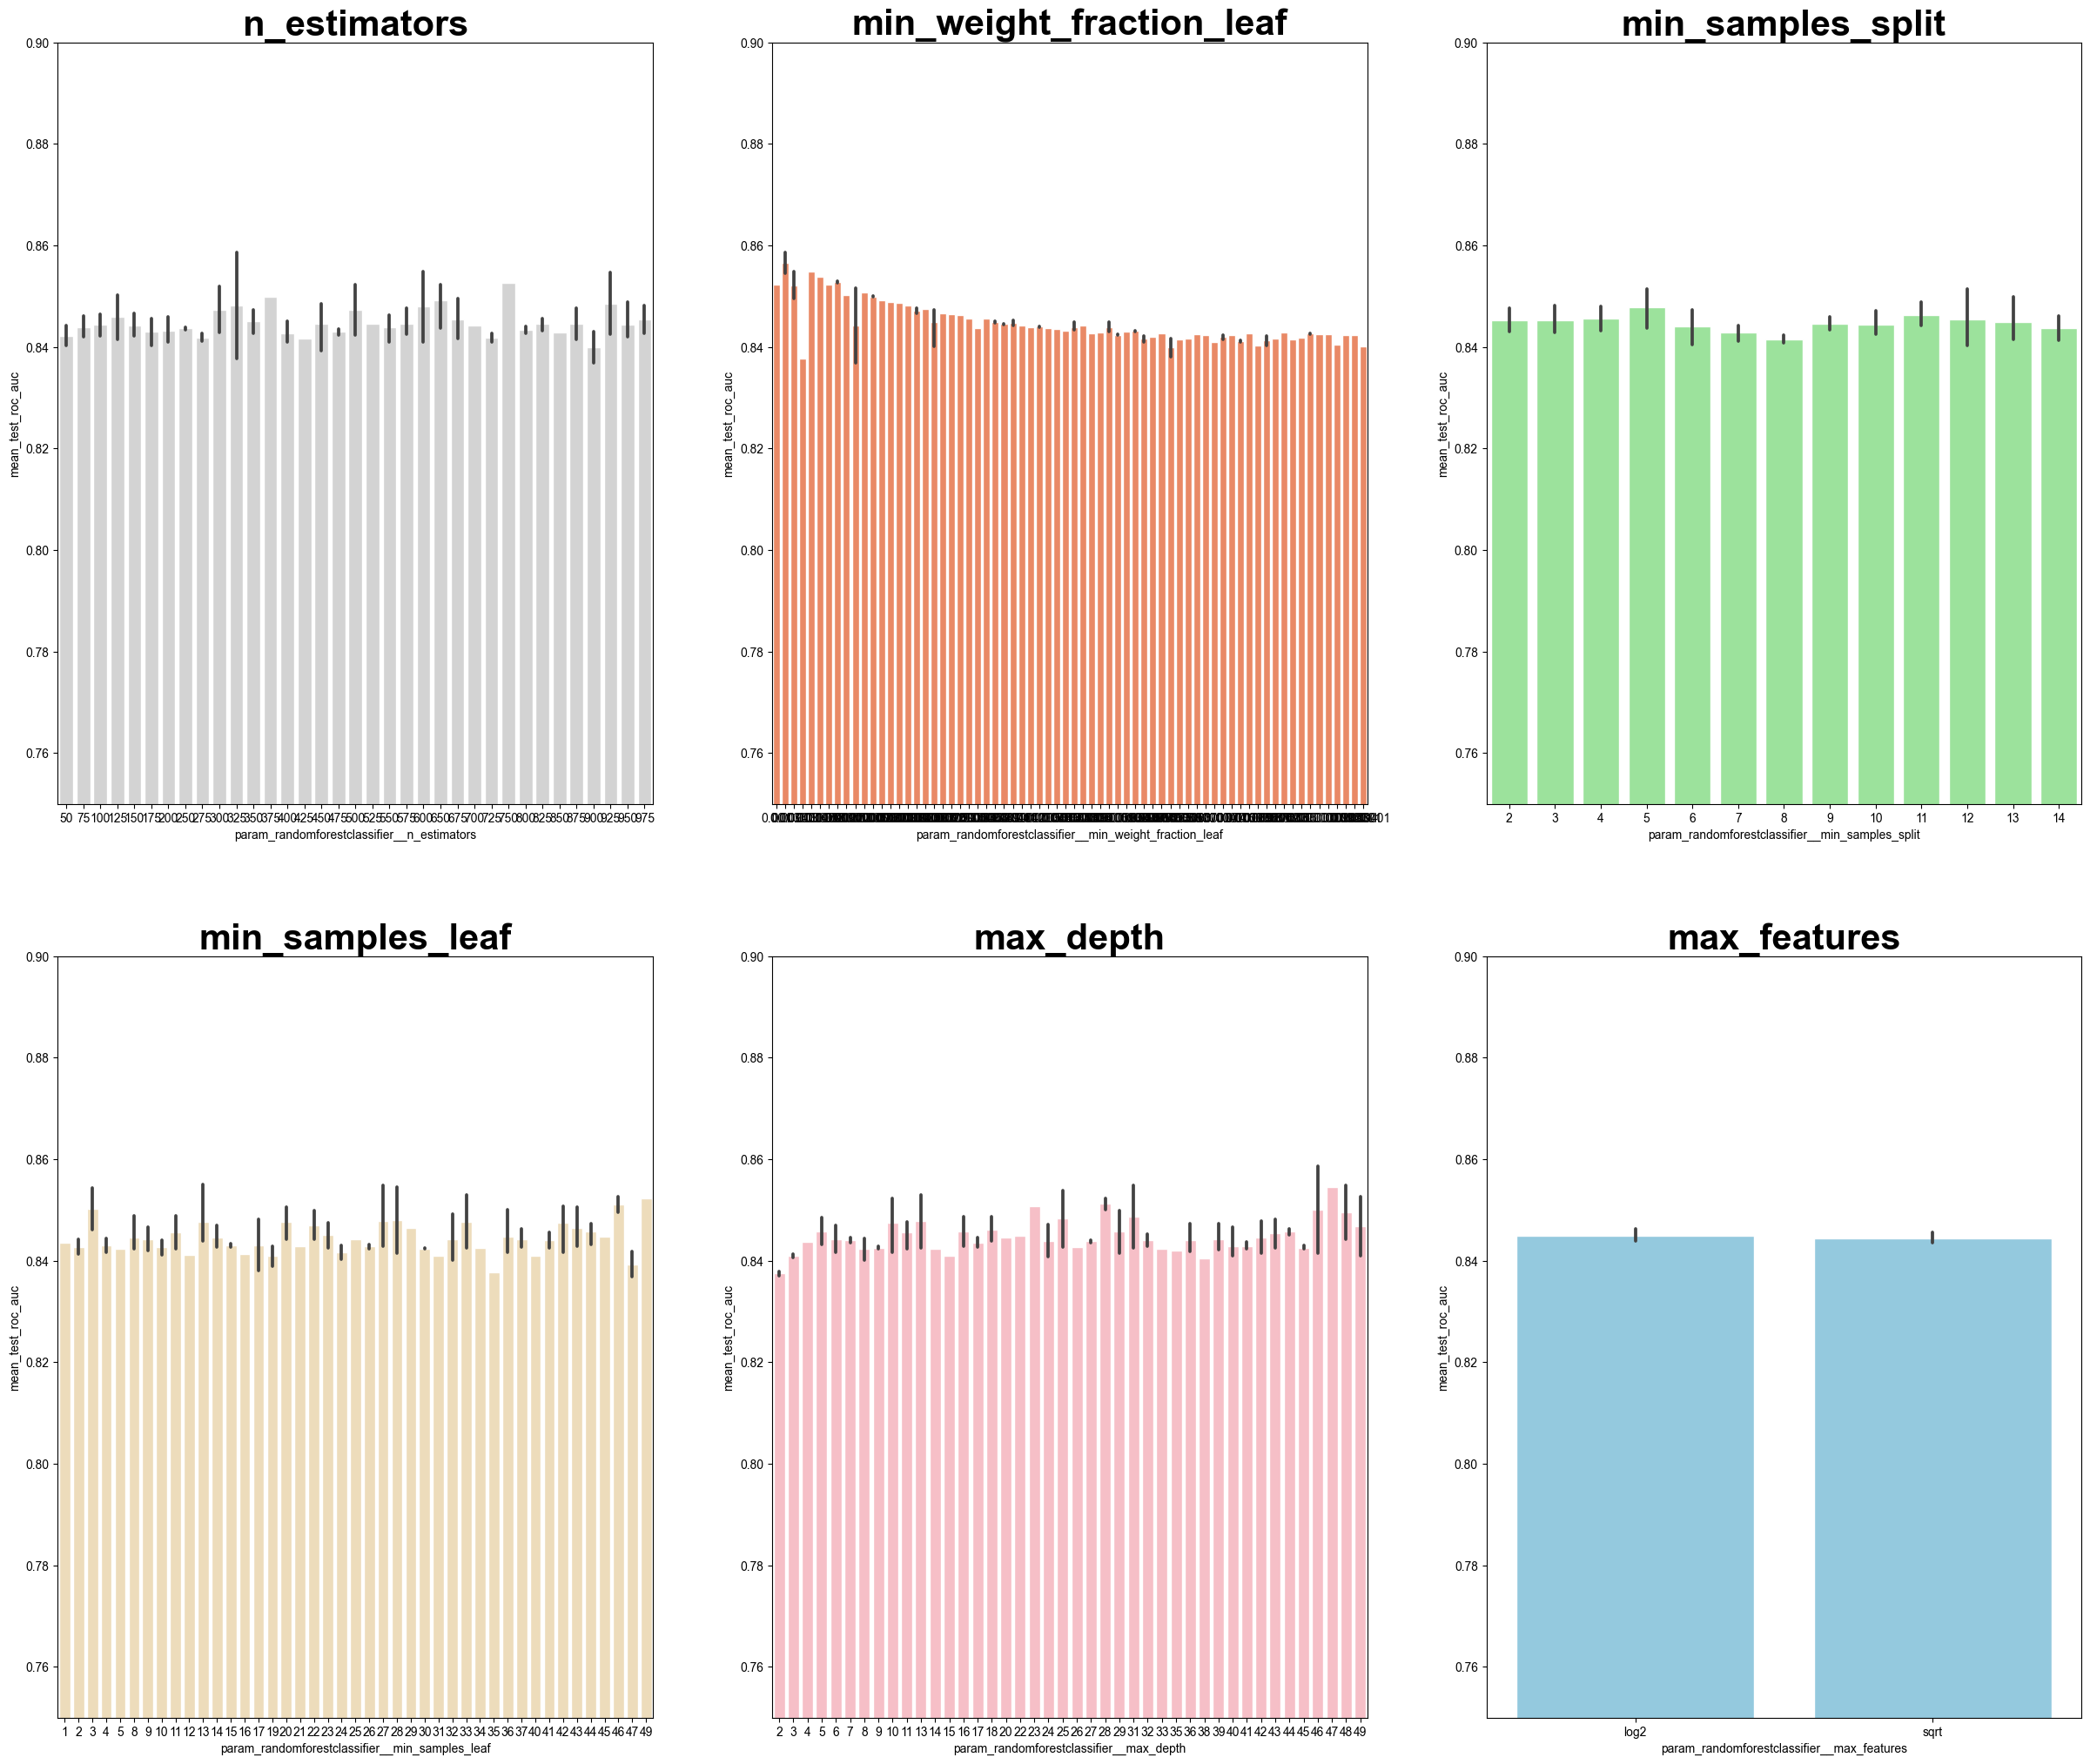

In [117]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
barplot_ax('param_randomforestclassifier__n_estimators', 
           'mean_test_roc_auc', 
           rs_rf, 
           0, 0, 
           .75,.90,
           30, 
           'lightgrey', 
           'n_estimators')

barplot_ax('param_randomforestclassifier__min_weight_fraction_leaf', 
           'mean_test_roc_auc', 
           rs_rf, 
           0, 1, 
           .75,.90,
           30, 
           'coral', 
           'min_weight_fraction_leaf')

barplot_ax('param_randomforestclassifier__min_samples_split', 
           'mean_test_roc_auc', 
           rs_rf, 
           0, 2, 
           .75,.90,
           30, 
           'lightgreen', 
           'min_samples_split')

barplot_ax('param_randomforestclassifier__min_samples_leaf', 
           'mean_test_roc_auc', 
           rs_rf, 
           1, 0, 
           .75,.90,
           30, 
           'wheat', 
           'min_samples_leaf')

barplot_ax('param_randomforestclassifier__max_depth', 
           'mean_test_roc_auc', 
           rs_rf, 
           1, 1, 
           .75,.90,
           30, 
           'lightpink', 
           'max_depth')

barplot_ax('param_randomforestclassifier__max_features', 
           'mean_test_roc_auc', 
           rs_rf, 
           1, 2, 
           .75,.90,
           30, 
           'skyblue', 
           'max_features')

plt.show()

#### Построим модель на основе перебора найденных параметров в GridSearchCV

In [118]:
def param_rf(df, parm_name, test_score, interval):
    param = df.groupby(parm_name)[test_score].mean(
    ).sort_values(ascending=False).index[0:interval].to_list()
    return param

In [119]:
%%time
n_estimators = param_rf(rs_rf, 
                        'param_randomforestclassifier__n_estimators', 
                        'mean_test_roc_auc', 2)

max_depth = param_rf(rs_rf, 
                        'param_randomforestclassifier__max_depth', 
                        'mean_test_roc_auc', 3)

max_features = param_rf(rs_rf, 
                        'param_randomforestclassifier__max_features', 
                        'mean_test_roc_auc', 1)

fraction_leaf = param_rf(rs_rf, 
                        'param_randomforestclassifier__min_weight_fraction_leaf', 
                        'mean_test_roc_auc', 3)

min_samples_split = param_rf(rs_rf, 
                        'param_randomforestclassifier__min_samples_split', 
                        'mean_test_roc_auc', 3)

min_samples_leaf = param_rf(rs_rf, 
                        'param_randomforestclassifier__min_samples_leaf', 
                        'mean_test_roc_auc', 3)

bootstrap = param_rf(rs_rf, 
                        'param_randomforestclassifier__bootstrap', 
                        'mean_test_roc_auc', 1)



param_grid_rf_v1 = {
    'randomforestclassifier__n_estimators': n_estimators, 
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__min_weight_fraction_leaf': fraction_leaf,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__bootstrap': bootstrap
}

gs_rf_v1 = train_model_gs(
                              RandomForestClassifier, 
                              col_transformer_rf, 
                              ['roc_auc', 'accuracy', 'f1'], 5, 
                              X_train_rforest, y_train, 
                              RANDOM_STATE, 
                              param_grid_rf_v1)

rf1_metric = best_metric('RandomForestClassifier', gs_rf_v1)

best_params: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 47, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_weight_fraction_leaf': 0.003, 'randomforestclassifier__n_estimators': 750}
AUC: 0.858
Accuracy: 0.772 
F1: 0.643
CPU times: total: 14.2 s
Wall time: 9min 44s


### Подбираем гиперпараметры с помощью GridSearchCV для модели HistGradientBoostingClassifier


In [120]:
%%time
param_grid_hgb = {
    "histgradientboostingclassifier__learning_rate": np.arange(.001, .3, .001),
    "histgradientboostingclassifier__min_samples_leaf": range(10, 300, 10),
    "histgradientboostingclassifier__max_depth": range(2, 50, 1),
    "histgradientboostingclassifier__max_bins": range(10, 250, 10)
    }

gs_hgb = train_model_rs(HistGradientBoostingClassifier, 
                            col_transformer_rf, 
                            ['roc_auc', 'accuracy', 'f1'], 5, 
                            X_train_rforest, y_train, 
                            RANDOM_STATE, param_grid_hgb)

hgb_metric = best_metric('RandomForestClassifier', gs_hgb)

best_params: {'histgradientboostingclassifier__min_samples_leaf': 80, 'histgradientboostingclassifier__max_depth': 41, 'histgradientboostingclassifier__max_bins': 160, 'histgradientboostingclassifier__learning_rate': 0.241}
AUC: 0.897
Accuracy: 0.853 
F1: 0.696
CPU times: total: 13.4 s
Wall time: 1min 19s


Перебрав разные гиперпараметры достичь заданного порога качества модели не удалось. Применим апсемплинг и доунсемплинг к обучающим данным.

### Применение к данным метода апсемплинга методом CatsBoost

In [121]:
cln_cat = X_train_rforest.select_dtypes(include='object').columns.to_list()
pool_train = Pool(X_train_rforest, label=y_train, 
                  cat_features=cln_cat)

In [122]:
kitten = CatBoostClassifier(**{'grow_policy': 'Lossguide','eval_metric': 'AUC:hints=skip_train~false', 
                                'loss_function': 'Logloss', 'auto_class_weights': 'Balanced', 
                                'logging_level': 'Silent', 'random_state': RANDOM_STATE, 
                               'thread_count': -1})
params = {'max_depth': [2, 3, 7]}

In [123]:
%%time
grid_search_result = kitten.grid_search(params, X=pool_train)

0:	loss: 0.8668246	best: 0.8668246 (0)	total: 20.3s	remaining: 40.6s
1:	loss: 0.8879235	best: 0.8879235 (1)	total: 59.3s	remaining: 29.7s
2:	loss: 0.9122903	best: 0.9122903 (2)	total: 4m 22s	remaining: 0us
Estimating final quality...
CPU times: total: 32min 33s
Wall time: 17min 34s


In [124]:
detpth = grid_search_result.get('params').get('depth')
print('Max detpth:', detpth)

Max detpth: 7


In [125]:
icat = CatBoostClassifier(**{'max_depth': detpth,
                            'loss_function': 'Logloss',
                            'logging_level': 'Silent',
                            'eval_metric': 'AUC:hints=skip_train~false',
                            'grow_policy': 'Lossguide',
                            'random_state': RANDOM_STATE})

In [126]:
%%time
icat.fit(pool_train)

CPU times: total: 4min 8s
Wall time: 3min 2s


In [127]:
icat.get_best_score()

{'learn': {'Logloss': 0.20668661618658116, 'AUC': 0.9762962223388076}}

In [128]:
icat_preds = icat.predict_proba(pool_train)[:,1]
icat_prediction = icat.predict(pool_train)

In [129]:
auc = round(eval_metric(y_train, icat_preds, "AUC")[0], 3) # фиксируем AUC
accuracy =  round(eval_metric(y_train, icat_prediction, "Accuracy")[0], 3) # фиксируем accurasy
f1 =  round(eval_metric(y_train, icat_prediction, "F1")[0], 3)# фиксируем f1
    
icat_metrics = [['CatBoostClassifier', auc, accuracy, f1]]
icat_metrics_to_df = pd.DataFrame(icat_metrics, columns=['model', 'AUC', 'F1', 'Accurasy'])
display(icat_metrics_to_df)

,model,AUC,F1,Accurasy
0,CatBoostClassifier,0.971,0.92,0.836


### Сводная таблица по лучшим параметрам

In [130]:
frames = [lr_metric, rf_metric, rf1_metric, hgb_metric, icat_metrics_to_df]
df_metrc = pd.concat(frames)
display(df_metrc)

,model,AUC,F1,Accurasy
0,LogisticRegression,0.844624,0.753505,0.632151
0,RandomForestClassifier,0.858610,0.815698,0.604683
0,RandomForestClassifier,0.857586,0.771707,0.643207
0,RandomForestClassifier,0.897386,0.852673,0.696343
0,CatBoostClassifier,0.971000,0.920000,0.836000


### Тест лучшей модели

In [133]:
best_model_preds = icat.predict_proba(X_test_rforest)[:,1]
best_model_predict = icat.predict(X_test_rforest)
auc_b = roc_auc_score(y_test, best_model_preds) # считаем auc
accuracy_b =  accuracy_score(y_test, best_model_predict) # считаем accurasy
f1_b =  f1_score(y_test, best_model_predict)# считаем f1
print('AUC: {:.3f}\nAccuracy: {:.3f}\nF1: {:.3f}'.format(auc_b, accuracy_b, f1_b))

AUC: 0.914
Accuracy: 0.861
F1: 0.706


In [145]:
target_names = ['Текущий клиент, [0]','Клиент, отказавшийся от услуг компании, [1]'] 

print(classification_report(y_test, best_model_predict, target_names=target_names))

                                             precision    recall  f1-score   support

                        Текущий клиент, [0]       0.88      0.95      0.91      1291
Клиент, отказавшийся от услуг компании, [1]       0.81      0.63      0.71       467

                                   accuracy                           0.86      1758
                                  macro avg       0.84      0.79      0.81      1758
                               weighted avg       0.86      0.86      0.86      1758



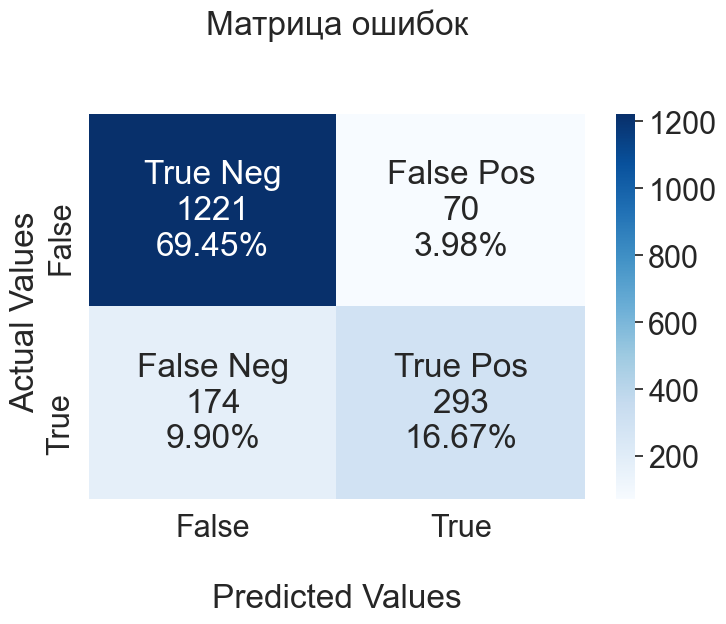

In [146]:
# Первоисточник кода:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

cnf_matrix = confusion_matrix(y_test, best_model_predict)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8, 5))

ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

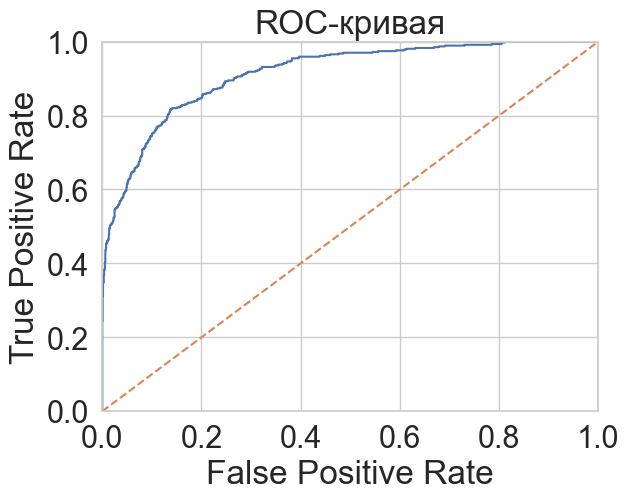

In [147]:
fpr, tpr, thresholds = roc_curve(y_test, best_model_preds)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.show()

In [136]:
X_test_gs_rf = pd.DataFrame(
    col_transformer_rf.fit_transform(X_test_rforest),
    columns=col_transformer_rf.get_feature_names_out()
)

In [137]:
forest_model_basic_results = pd.DataFrame({
                        'Features': X_test_gs_rf.columns,
                        'Importances': (gs_rf_v1.best_estimator_._final_estimator.feature_importances_ * 100)
                                        }).sort_values('Importances', ascending=False)

display(forest_model_basic_results)

,Features,Importances
34,standardscaler__day_of_use,19.395382
30,ordinalencoder__Type,18.442197
31,standardscaler__TotalCharges,10.302883
25,onehotencoder__connected_services_Phone and Fi...,7.106135
7,onehotencoder__InternetService_Fiber optic,5.906842
2,onehotencoder__PaymentMethod_Electronic check,4.096140
10,onehotencoder__OnlineSecurity_Yes,2.745812
29,onehotencoder__total_charges_category_D,2.714146
33,standardscaler__additional_services,2.367990
24,onehotencoder__connected_services_Phone and DSL,1.986520


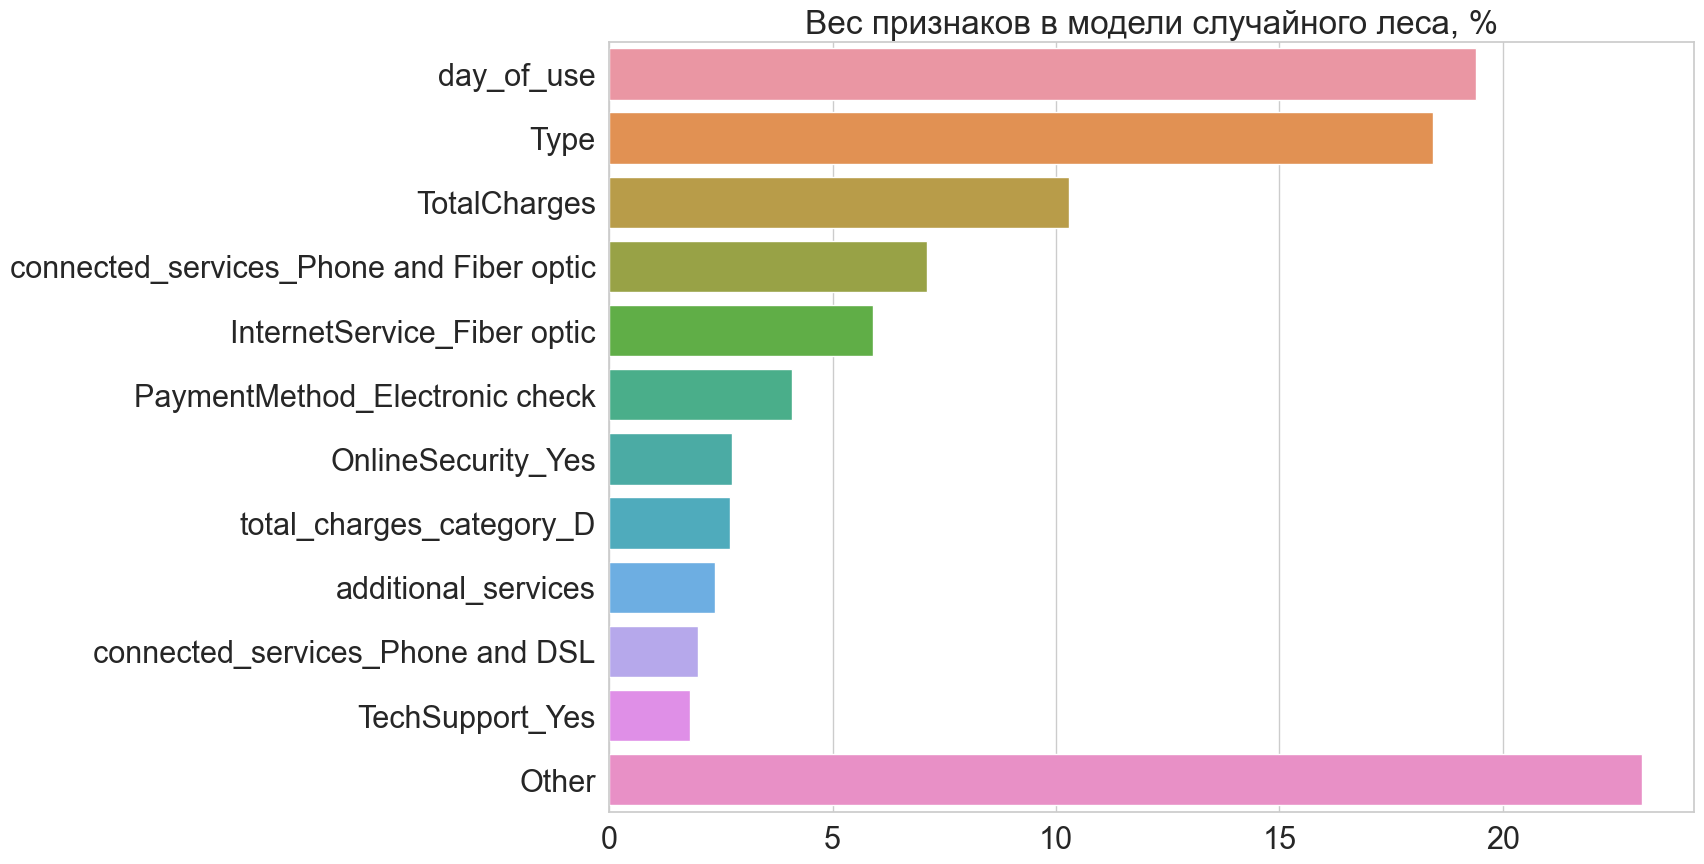

In [138]:
forest_top_feature_importances = forest_model_basic_results.head(11) # выделяем десять первых признаков

remains = forest_model_basic_results.tail((forest_model_basic_results.Features.count() - 11))
remains = remains.Importances.sum()
remains = pd.DataFrame({'Features': ['Other'], 'Importances': [remains]})
# подсчитываем остаток

forest_top_feature_importances = forest_top_feature_importances.append(remains)
# добавляем остаток для наглядности

forest_top_feature_importances['Features'] = forest_top_feature_importances[
    'Features'].replace(
    to_replace = '^onehotencoder__', 
    value = '', 
    regex = True
)
forest_top_feature_importances.Features = forest_top_feature_importances[
    'Features'].replace(
    to_replace = '^standardscaler__', 
    value = '', 
    regex = True
)
forest_top_feature_importances.Features = forest_top_feature_importances[
    'Features'].replace(
    to_replace = '^ordinalencoder__', 
    value = '', 
    regex = True
)

plt.figure(figsize=(14, 10))
sns.barplot(x='Importances', y='Features', data=forest_top_feature_importances)
plt.title('Вес признаков в модели случайного леса, %')
plt.xlabel('')
plt.ylabel('')
plt.show()

**Вывод:**

1. Заданная метрика достигнута. AUC ROC 0.914. Однако предсказания модели далеки от идеала. **37.2%** покинувших компанию клиентов она определила как клиентов сохранивших договор. При этом **62.7%** пользователей, которые покинули компанию она определила верно. Также по результату работы модели из всех предсказанных в отток клиентов **19.3%** клиентов на самом деле не отказались от услуг. 

- Таким образом модель с точностью более 80% делает предсказание по оттоку клиентов. Однако охватывает лишь около 63% клиентов, которые действительно покинут компанию.

2. Количество дней использования имеет наибольший вес в модели CatsBoost (**19.4 %**). Прямое кодирование признака с типом договора (Type) сказалось положительно. Вес признака в модели **18.44%**. Также большой вес имее признак, отражающий поключенные услуги (connected_service). Суммарно **10.69%**.

## Отчет

### В рамках проекта  построена модель по прогнозированию оттока клиентов оператора сотовой связи и выполнены все пункты обозначенные в плане. Однако не в полной мере:



##### Так при выполнении [п. 2](#tag_1) плана пришлось отказаться от идеи разбивки данных с привязкой ко времени.

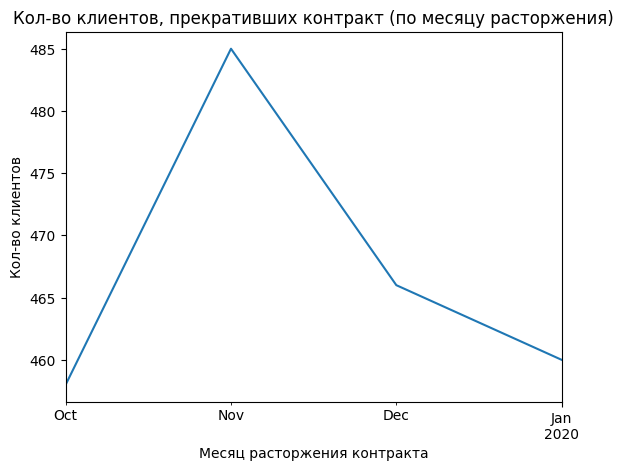

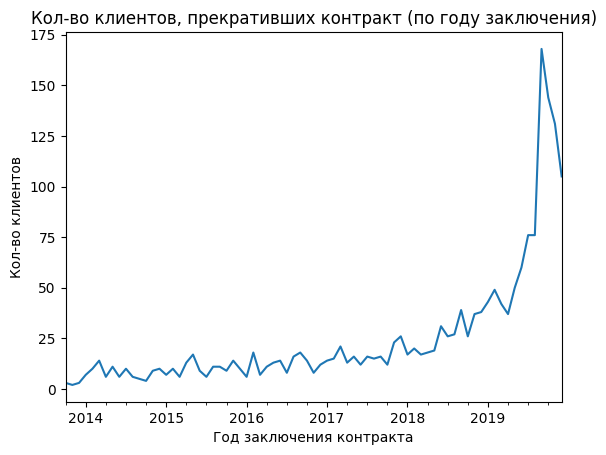

Количество расторгнутых контрактов выглядит равномерно с пиком в ноябре 2019 года. Данные по расторгнутым контрактам лишь за период с октября 2019 по января 2020. Однако в контексте даты заключения контракта данные распределены более равномерно. 


Странно, но многие локальные пики приходятся на контракты, заключенные первые месяцы года.


Поскольку данные по оттоку представлены за 4 месяца, а по заключению контракта за несколько лет, временным рядом их считать нельзя. Делить выборки будем исходя из этого.

##### При выполнении [п. 3](#tag_1) плана оказалось целесообразным пребегнуть к порядковому кодированию признака с типом контракта (Type) для модели случайного леса.

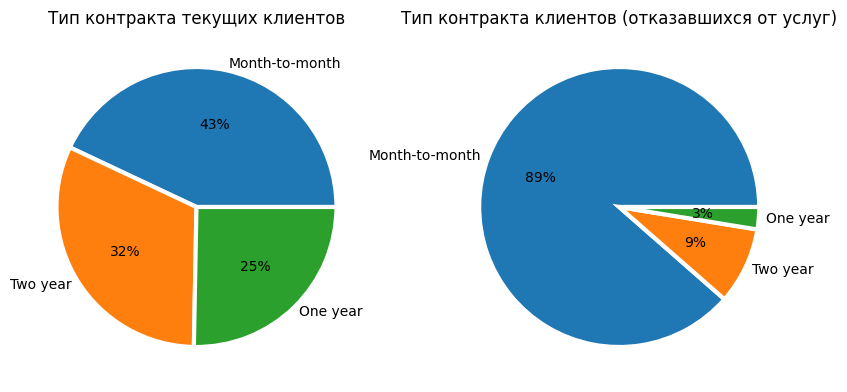

,Type
Month-to-month,2220
Two year,1637
One year,1306
,Type
Month-to-month,1655
One year,166
Two year,48


Среди текущих клиентов контракты распределены соизмеримо. Среди клиентов, которые отказались от услуг компании, подавляющее большинство заключали ежемесячный контракт (**89%**). 

При этом среди текущих клиентов все равно в наибольшой степени также преобладает ежемесячный тип контракта (**43%**). 

Возможно их удержание послужит точкой роста. Также это скорее всего приведет к доминирующему преобладанию ежемесячного типа контракта. Прибегнем к порядковому кодированию, чтобы комплексно посмотреть на значимость данного признака.

### В рамках проекта в первую очердь данные были извлечены и исследованы


#### При первичной обработке данных выявлены и удалены неявные дубликаты

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not connected
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Not connected
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,Not connected,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Столбец TotalCharges наравне с числовыми элементами содержит пробел. Очевидно это обусловлено тем, что некоторые клиенты пользуются услугами компании менее месяца. Удалим эти данные, после чего преобразуем остальное во float.

#### Признаки BeginDate и EndDate преобразованы в datetime

Отсутствие данных о рассторжении контракта 'No' из признака EndDate заменены на данные о месяце выгрузки данных из BeginDate.

#### При проведении исследовальского анализа данных выявлены возможные негативные тенденции для бизнеса

##### В компании наблюдается негативная динамика оттока клиентов

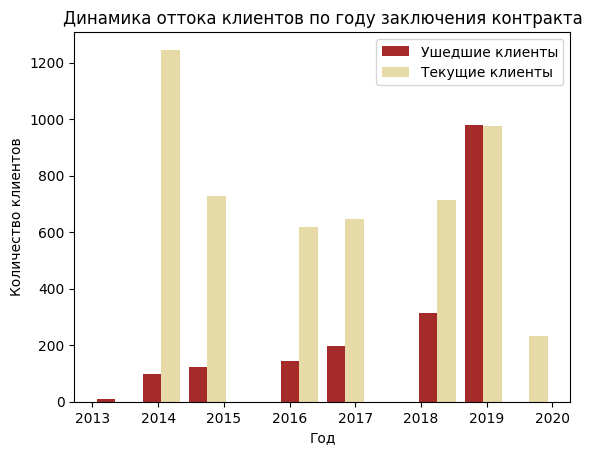

Представлены неполные данные. Данные об оттоке клиентов представлены только за период с 10.2019 по 02.2020. За период с 10.2013 по 09.2019 представлены только данные о заключенных контрактах, большинство из которых не были расторгнуты. Наибольшее число расторгнутых контрактов были заключены в 2019 году. Но даже в таком контексте наблюдается негативная динамика и увеличение оттока клиентов.

##### Большинство отказавшихся от услуг компании клиентов пользовались Интернетом, предоставляемым через оптоволоконный кабель

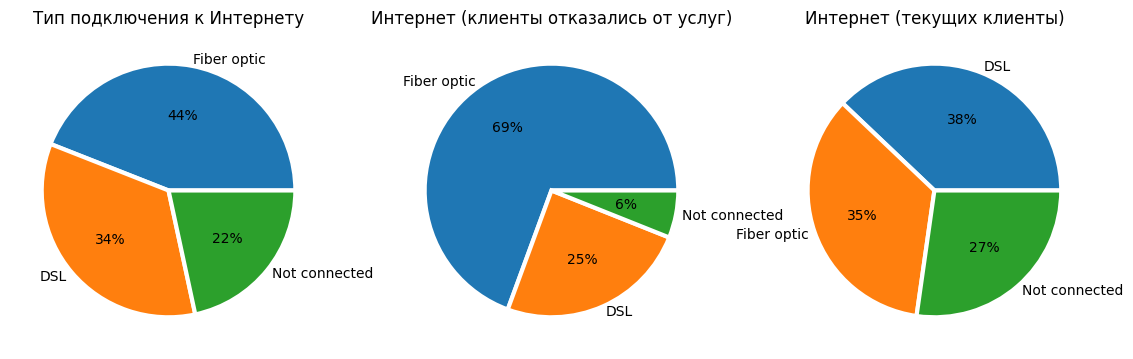

,InternetService
Fiber optic,3096
DSL,2416
Not connected,1520
,InternetService
Fiber optic,1297
DSL,459
Not connected,113
,InternetService
DSL,1957
Fiber optic,1799


Подавляющее большинство клиентов (**69%**), отказавшихся от услуг интернета пользовались оптоволоконным кабелем. На это стоит обратить внимание. С учетом того, что количество клиентов пользующиеся оптоволоконным кабелем и DSL примерно равно (**32% DSL и 44% оптоволокно**), отток клиентов может быть связан с техническими проблемами или более привлекательными предложениями конкурентов. Также важно заметить, что все пользователи оптоволокном также пользуются и услугами телефонной связи.

#### На основе проведенных исследований введены следующие синтетические признаки:

- **refused_services** - целевой признак. Выведен на основании EndDate.


- **additional_services** - к услугам использования Интернета предлагаются до 6 дополнительных услуг. Их суммарное количество у каждого клиенто выделено в отдельный признак. Признак выведен из суммы признаков (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) с учетом тех, у кого Интернет не подключен (заглушка -1)


- **months_of_use** - отражает продолжительность использования услуг клинтом. Выведен из признаков EndDate и BeginDate. Наибольший отток клиентов наблюдается в первый месяц после заключения контракта. Значение оттока клиентов стабилизируется после полугода использования услуг компании. 


- **day_of_use** - отражает продолжительность использования услуг клинтом. Также выведен из признаков EndDate и BeginDate. Оказался эффективнее признака **months_of_use** и помог повысить уровень ключевой метрики выше заданного порога.


- **connected_services** - исходя из того, что 68% пользуются услугами интенета и телефона, информаци об этом объединена в отдельный признак. Выведен из признаков InternetService и MultipleLines.


- **monthly_charges_category** - отражает квантили ежемесячных трат из признака MonthlyCharges.


- **total_charges_category** - отражает квантили ежемесячных трат из признака TotalCharges.


- **automatic_payment** - выведен на основе признака PaymentMethod и отражает, является ли платеж автоматическим.


- **phone** - признак выведен из MultipleLines и свидетельствует о подключении услуг телефонии.


- **month** - месяц заключения контракта выведен из BeginDate.


- **year** - год заключения контракта выведен из BeginDate.

### Данные разделены на обучающую и тестовую выборки для регрессионной и ансамблевых моделей.

С учетом дисбаланса данных применена стратификация. Выборки разделены в соотношении 3/1.

#### Признаки, исключенные из использования в ансамблевых моделях:

- **customerID** - признак неинформативен, отражает id клиента в системе.


- **EndDate** - на основе этого признака выведен целевой признак.


- **BeginDate, year, month** - данные о расторжении контрактов представлены за 4 месяца, о заключении контрактов за 6 лет. Данный признак приведен к утечке данных и неккоректым предсказаниям.


- **months_of_use** - заменен признаком day_of_use который делает значение промежутков времени больше, а значит увеличивает и разницу в весах.


- **MonthlyCharges** - в сочетании с TotalCharges и months_of_use приведет к утечке данных. Один признак можно будет вывести из другого. В ансамблевых моделях имеет значимость ниже, чем у TotalCharges.



Признаки показали значимость на ансамблевых моделях значительно ниже 1%: 
- onehotencoder__monthly_charges_category
- onehotencoder__MultipleLines
- onehotencoder__phone_Yes
- onehotencoder__Partner_Yes
- onehotencoder__Dependents_Yes
- onehotencoder__gender_Male
- remainder__SeniorCitizen

Оставшиеся признаки преобразованы прямым кодированием и масштабированы, Type преобразован порядковым кодированием.

#### Признаки для регрессионной модели были выбраны с учетом коэффециента инфляции дисперсии после чего преобразованы прямым кодированием и масштабированы:

ordinalencoder__Type                   4.226091
ordinalencoder__PaperlessBilling       2.841440
ordinalencoder__PaymentMethod          8.314865
ordinalencoder__gender                 1.980865
ordinalencoder__Partner                2.791373
ordinalencoder__Dependents             1.968274
ordinalencoder__OnlineSecurity         2.351911
ordinalencoder__OnlineBackup           2.440676
ordinalencoder__DeviceProtection       2.653071
ordinalencoder__TechSupport            2.513119
ordinalencoder__StreamingTV            3.009351
ordinalencoder__StreamingMovies        3.050360
ordinalencoder__MultipleLines          2.510375
ordinalencoder__connected_services     7.451084
ordinalencoder__automatic_payment      5.219257
standardscaler__TotalCharges           8.618886
standardscaler__refused_services       1.365532
standardscaler__additional_services    2.315547
standardscaler__day_of_use             7.179442
remainder__SeniorCitizen               1.357214
dtype: float64

### Ряд моделей обучены на выделенных данных с подбором гиперпараметров с помощью кроссвалидафии посредствам GridSearchCV, RandomizedSearchCV и grid_search

,model,AUC,F1,Accurasy
0,LogisticRegression,0.844624,0.753505,0.632151
0,RandomForestClassifier,0.858610,0.815698,0.604683
0,RandomForestClassifier,0.857586,0.771707,0.643207
0,RandomForestClassifier,0.897386,0.852673,0.696343
0,CatBoostClassifier,0.971000,0.920000,0.836000


#### Параметры лучшей модели CatBoostClassifier:

- {'max_depth': 7, 'loss_function': 'Logloss', 'logging_level': 'Silent', 'eval_metric': 'AUC:hints=skip_train~false', 'random_state': 130223}

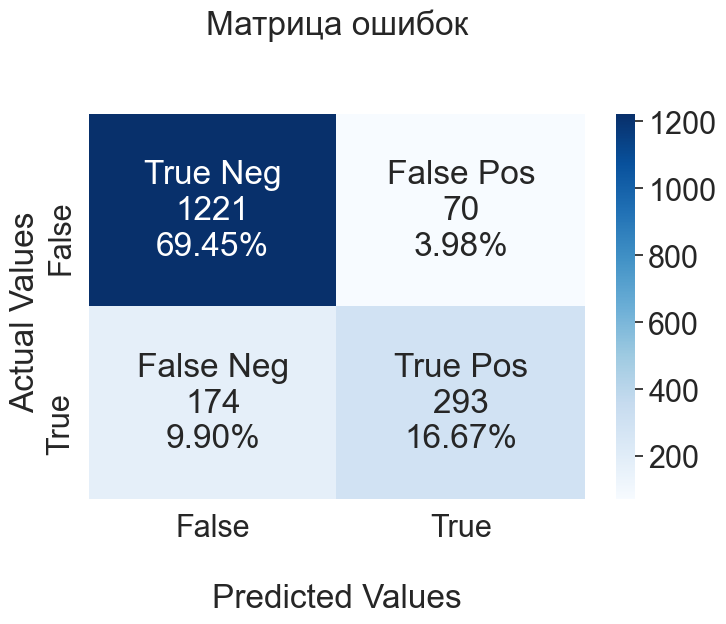

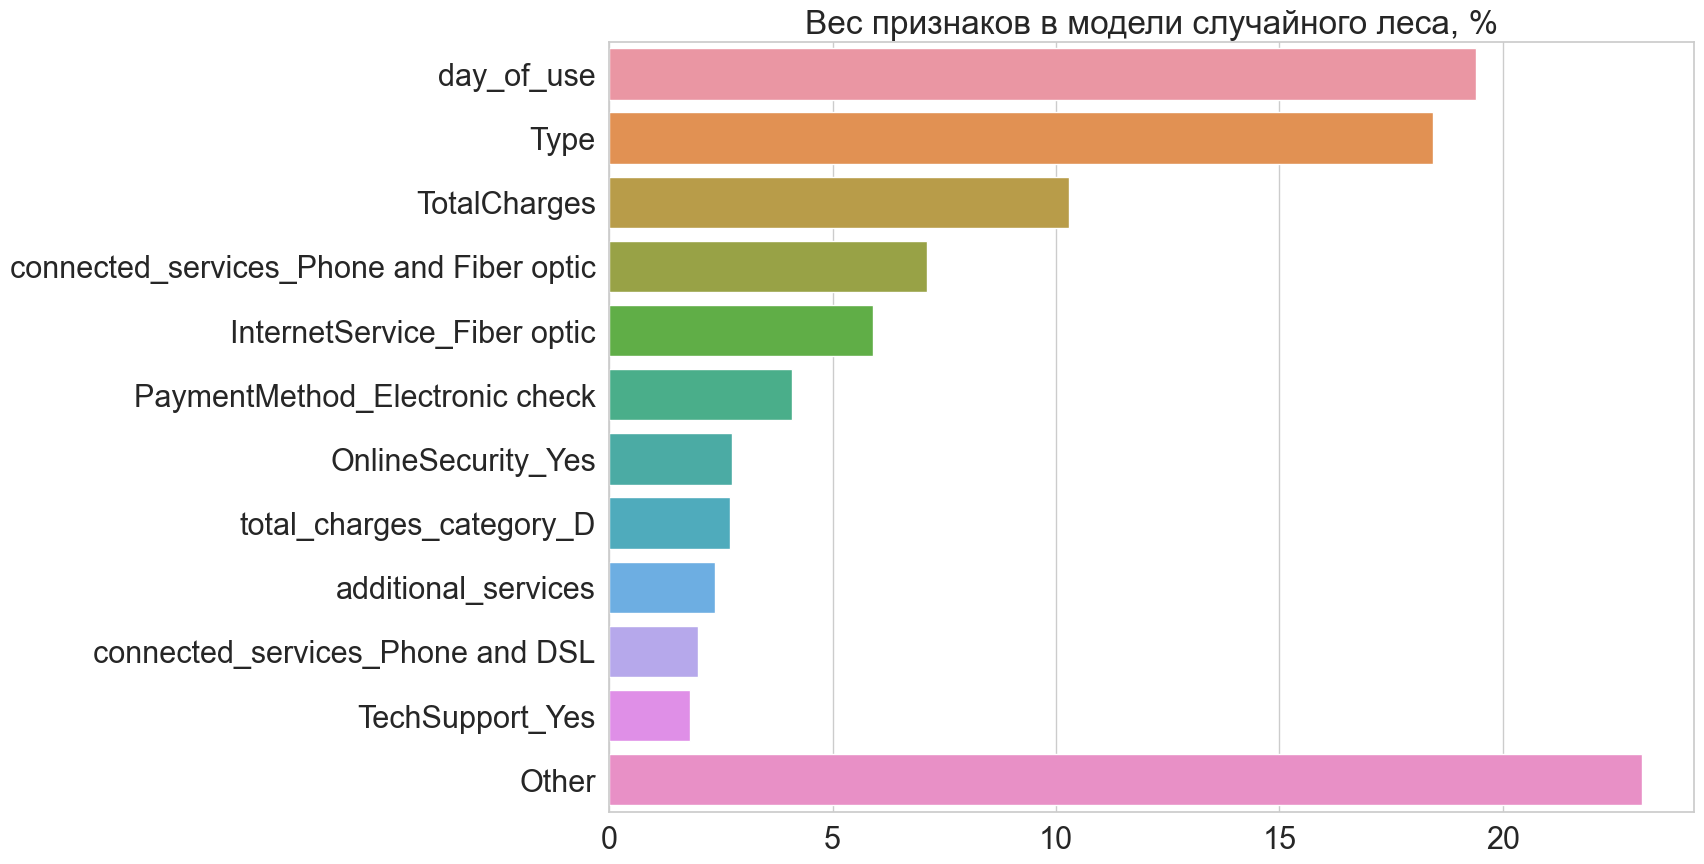

- Заданная метрика достигнута (AUC_ROC = 0.914) Однако предсказания модели далеки от идеала. **37.2%** покинувших компанию клиентов она определила как клиентов сохранивших договор. При этом **62.7%** пользователей, которые покинули компанию она определила верно. Также по результату работы модели из всех предсказанных в отток клиентов **19.3%** клиентов на самом деле не отказались от услуг. Таким образом модель с точностью более 80% делает предсказание по оттоку клиентов. Однако охватывает лишь около 63% клиентов, которые действительно покинут компанию.



- Количество дней использования имеет наибольший вес в модели CatsBoost (**19.4 %**). Прямое кодирование признака с типом договора (Type) сказалось положительно. Вес признака в модели **18.44%**. Также большой вес имее признак, отражающий поключенные услуги (connected_service). Суммарно **10.69%**.


- Таким образом Топ-3 признаков (day_of_use, Type, connected_service) имеют суммарный вес в 48.58% и являются ключевыми для построения модели. При этом признаки, отражающие персональную информацию о клиенте (такие как пол или наличие супруга) не имею значения для построения модели. Одной из причин может быть недостаточная точность собранных данных.